# 1. Mount virtual drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# 2. Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas import ExcelWriter
from sklearn.metrics import accuracy_score, recall_score, auc, roc_curve, precision_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN, SMOTE
import warnings
warnings.filterwarnings("ignore")

# 3. Loading datasets

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/train.csv",encoding = 'ISO-8859-1')
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
address_df = pd.read_csv("/content/drive/MyDrive/addresses.csv")

train_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [ ]:
train_df.shape

(250306, 34)

# 4. Data cleaning and wrangling

### 4.1 Dropping variables that don't provide much information

This part is fairly simple after we take a cursory look at the variables and also look at any missing values. The following criteria was used for removing initial variables. 
- Variables that provide payment information, as that could lead to data leakage - **Ex. Late fee**
- Variables with too many missing/null values - **Ex. Violation zip code**
- Variables that contain too many categories 
- Variables that obviously do not seem to be good predictors of the target variable. **Ex. State** (since there is only one state, Michigan)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [ ]:
train_df = train_df.drop(['ticket_id','country','payment_date','payment_status','collection_status',
                          'grafitti_status','compliance_detail','violation_zip_code','non_us_str_code',
                          'payment_amount','late_fee','balance_due','state'],axis=1)
test_df = test_df.drop(['ticket_id','country','grafitti_status','violation_zip_code','non_us_str_code',
                        'late_fee','state'],axis=1)
train_df.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,zip_code,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,discount_amount,clean_up_cost,judgment_amount,compliance
0,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,3.0,S. WICKER,CHICAGO,60606,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,0.0,0.0,305.0,0.0
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,48208,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,0.0,0.0,855.0,1.0
2,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,23658.0,P.O. BOX,DETROIT,48223,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
3,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,5.0,ST. CLAIR,DETROIT,48214,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
4,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,7449.0,CHURCHILL,DETROIT,48206,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN


### 4.2 Dropping variables with too many unique values *OR* categories

Below we visualize the number of unique categories for each remaining variable in order to do further selection.

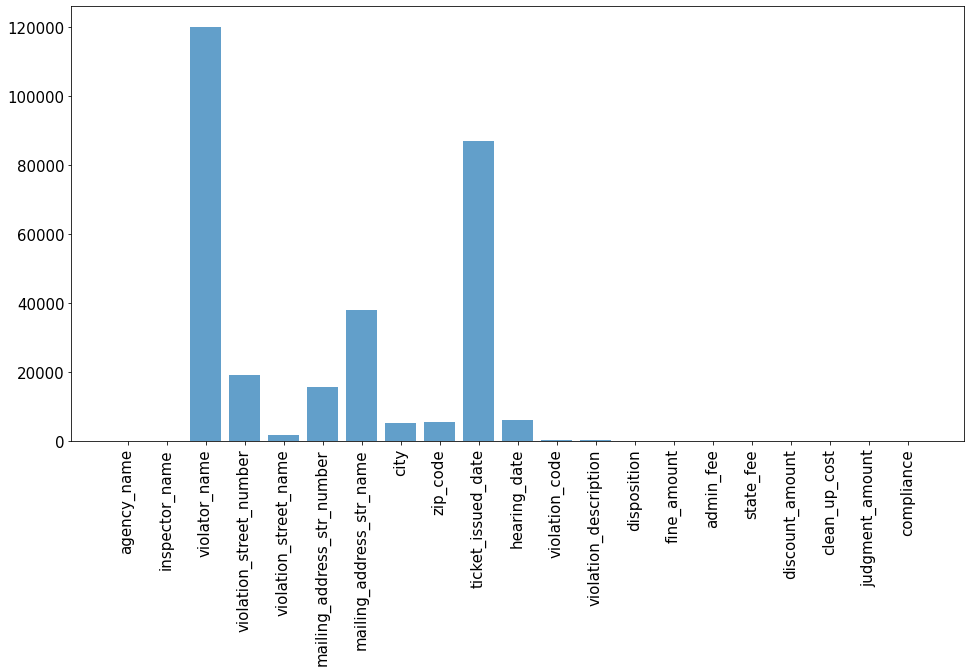

In [ ]:
unique_lens = []
for var in train_df.columns:
  unique_lens.append(len(train_df[var].unique()))

plt.figure(figsize=(16,8))
plt.bar(train_df.columns,unique_lens,alpha=0.7)
plt.xticks(rotation=90,size=15)
plt.yticks(size=15)
plt.show()

In [ ]:
#Exploring the unique values for categorical variables that have relatively lower categories
print ("Number of unique values in violation_code:",len(train_df['violation_code'].unique()))
print ("Number of unique values in violation_description:",len(train_df['violation_description'].unique()))
print ("Number of unique values in violation_street_name:",len(train_df['violation_street_name'].unique()))
print ("Number of unique values in disposition:",len(train_df['disposition'].unique()))
print ("Number of unique values in zip_code:",len(train_df['zip_code'].unique()))
print ("Number of unique values in inspector_name:",len(train_df['inspector_name'].unique()))

Number of unique values in violation_code: 235
Number of unique values in violation_description: 258
Number of unique values in violation_street_name: 1791
Number of unique values in disposition: 9
Number of unique values in zip_code: 5643
Number of unique values in inspector_name: 173


Variables that contain too many unique values to be useful for prediction: 

1. violator_name
2. violation_street_number
3. mailing_address_str_number
4. mailing_address_str_name
5. violation_street_name
6. violation_code
7. violation_description
8. zip_code

We can keep *ticket_issued_date* since we will be using it later for feature engineering. We drop the rest of the aforementioned variables. 


In [ ]:
train_df = train_df.drop(['violator_name','violation_street_number','mailing_address_str_number',
                          'mailing_address_str_name','violation_street_name',
                          'violation_code','violation_description','zip_code','inspector_name'],axis=1)
test_df = test_df.drop(['violator_name','violation_street_number','mailing_address_str_number',
                          'mailing_address_str_name','violation_street_name',
                          'violation_code','violation_description','zip_code','inspector_name'],axis=1)
train_df.head()

,agency_name,city,ticket_issued_date,hearing_date,disposition,fine_amount,admin_fee,state_fee,discount_amount,clean_up_cost,judgment_amount,compliance
0,"Buildings, Safety Engineering & Env Department",CHICAGO,2004-03-16 11:40:00,2005-03-21 10:30:00,Responsible by Default,250.0,20.0,10.0,0.0,0.0,305.0,0.0
1,"Buildings, Safety Engineering & Env Department",Detroit,2004-04-23 12:30:00,2005-05-06 13:30:00,Responsible by Determination,750.0,20.0,10.0,0.0,0.0,855.0,1.0
2,"Buildings, Safety Engineering & Env Department",DETROIT,2004-04-26 13:40:00,2005-03-29 10:30:00,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
3,"Buildings, Safety Engineering & Env Department",DETROIT,2004-04-26 13:30:00,NaN,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN
4,"Buildings, Safety Engineering & Env Department",DETROIT,2004-04-26 13:00:00,2005-03-29 10:30:00,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,NaN


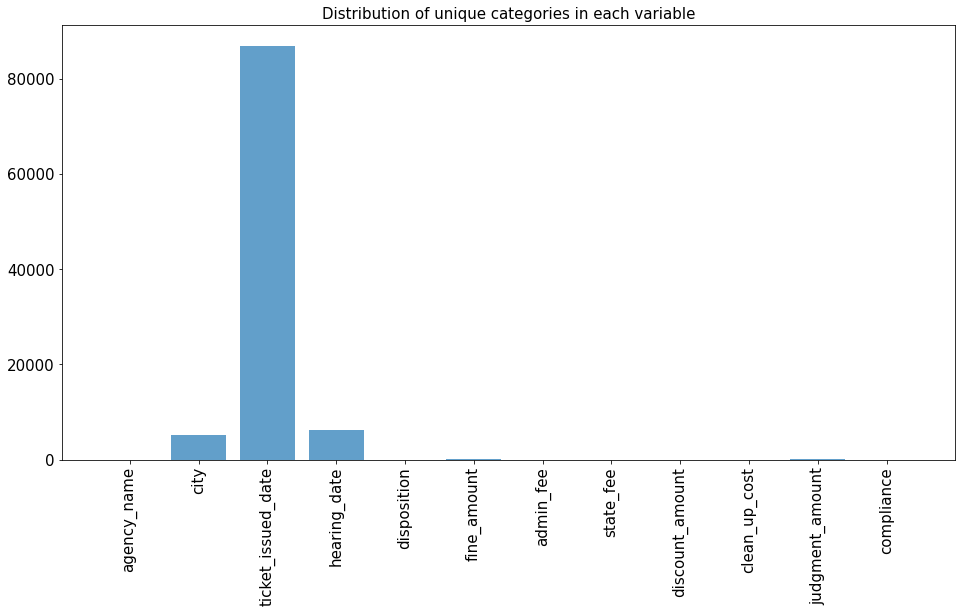

In [ ]:
unique_lens = []
for var in train_df.columns:
  unique_lens.append(len(train_df[var].unique()))

plt.figure(figsize=(16,8))
plt.bar(train_df.columns,unique_lens,alpha=0.7)
plt.xticks(rotation=90,size=15)
plt.yticks(size=15)
plt.title('Distribution of unique categories in each variable',size=15)
plt.show()

Above, we re-visualize the number of unique categories in the remaining variables to make sure that the feature selection worked. 

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   agency_name         250306 non-null  object 
 1   city                250306 non-null  object 
 2   ticket_issued_date  250306 non-null  object 
 3   hearing_date        237815 non-null  object 
 4   disposition         250306 non-null  object 
 5   fine_amount         250305 non-null  float64
 6   admin_fee           250306 non-null  float64
 7   state_fee           250306 non-null  float64
 8   discount_amount     250306 non-null  float64
 9   clean_up_cost       250306 non-null  float64
 10  judgment_amount     250306 non-null  float64
 11  compliance          159880 non-null  float64
dtypes: float64(7), object(5)
memory usage: 22.9+ MB


# 5. Cleaning and wrangling

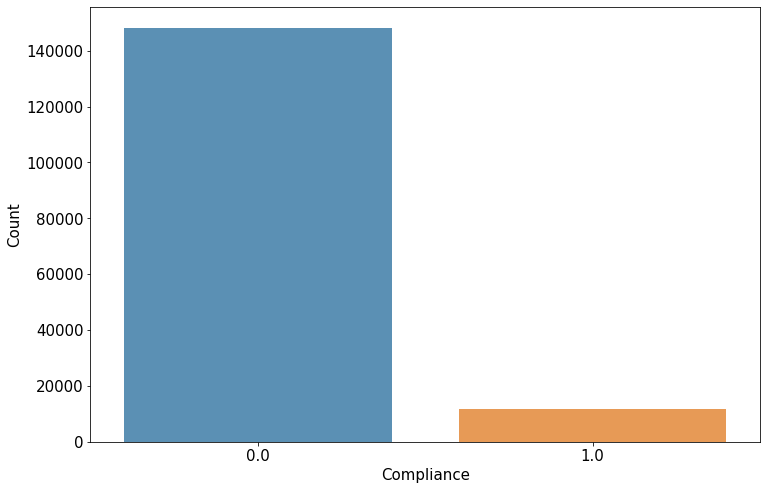

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=train_df,x='compliance',alpha=0.8)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Compliance',size=15)
plt.ylabel('Count',size=15)
plt.show()

In [ ]:
train_df['city'].value_counts()

DETROIT                136936
SOUTHFIELD              13436
Detroit                 10496
detroit                  4183
DEARBORN                 3637
                        ...  
W BLMFD                     1
MAUMEE                      1
Grapevine                   1
BELLVUE                     1
CHILWORTH ST MARTHA         1
Name: city, Length: 5184, dtype: int64

Next, we filter the dataset by the city of **Detroit** and then drop the *city* variable. 

In [ ]:
#Changing all city entries to upper case to make it simpler
train_df["city"] = train_df["city"].apply(str.upper)

In [ ]:
train_df['city'].value_counts()

DETROIT                151621
SOUTHFIELD              14760
DEARBORN                 4017
FARMINGTON HILLS         2508
OAK PARK                 2432
                        ...  
DORRHESTER                  1
CORAOPILIS                  1
HARISON TWP.                1
JONSONVILLE                 1
CHILWORTH ST MARTHA         1
Name: city, Length: 4324, dtype: int64

In [ ]:
#Filtering tickets only for the city of Detroit and then dropping the 'city' variable 
#since all instances would be for Detroit
train_df = train_df[train_df["city"]=="DETROIT"]
train_df = train_df.drop(["city"],axis=1)
test_df = test_df.drop(["city"],axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151621 entries, 1 to 250305
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   agency_name         151621 non-null  object 
 1   ticket_issued_date  151621 non-null  object 
 2   hearing_date        145058 non-null  object 
 3   disposition         151621 non-null  object 
 4   fine_amount         151620 non-null  float64
 5   admin_fee           151621 non-null  float64
 6   state_fee           151621 non-null  float64
 7   discount_amount     151621 non-null  float64
 8   clean_up_cost       151621 non-null  float64
 9   judgment_amount     151621 non-null  float64
 10  compliance          96001 non-null   float64
dtypes: float64(7), object(4)
memory usage: 13.9+ MB


In [ ]:
train_df['compliance'].isnull().sum()

55620

It looks like the compliance variable itself contains just 55620 values. Hence, in order to train our data, we would need to only select those observations that have a compliance value despite most of the variables having more than 15000 instances. 

Also, we only keep compliance values of either 0 or 1. 

In [ ]:
#Removing all 'not found responsible' compliance entries
train_df = train_df[(train_df["compliance"]==1.0) | (train_df["compliance"]==0.0)]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96001 entries, 1 to 250290
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   agency_name         96001 non-null  object 
 1   ticket_issued_date  96001 non-null  object 
 2   hearing_date        95884 non-null  object 
 3   disposition         96001 non-null  object 
 4   fine_amount         96001 non-null  float64
 5   admin_fee           96001 non-null  float64
 6   state_fee           96001 non-null  float64
 7   discount_amount     96001 non-null  float64
 8   clean_up_cost       96001 non-null  float64
 9   judgment_amount     96001 non-null  float64
 10  compliance          96001 non-null  float64
dtypes: float64(7), object(4)
memory usage: 8.8+ MB


# 5. EDA

### 5.1 Categorical variables

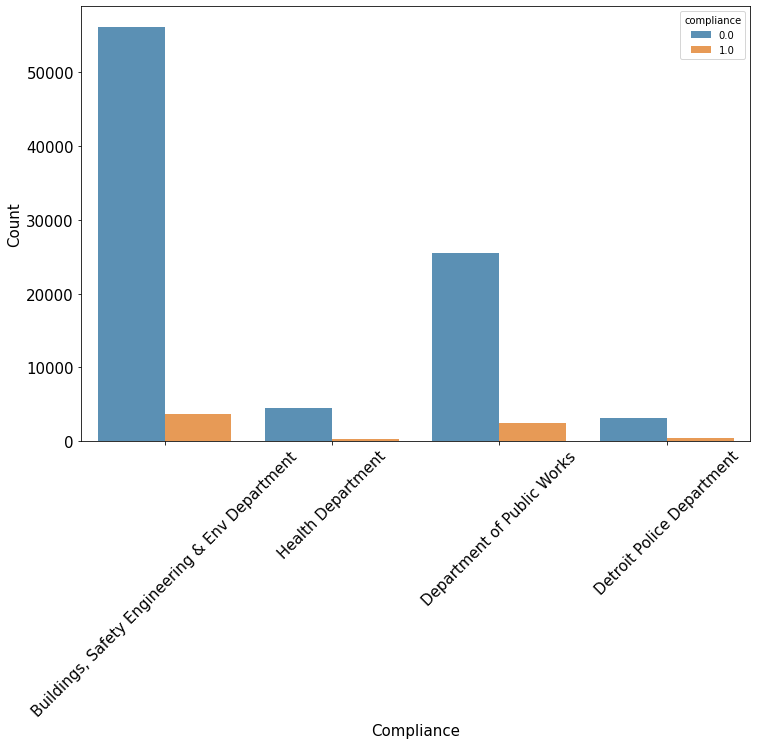

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=train_df,x='agency_name',hue='compliance',alpha=0.8)
plt.xlabel('Compliance',size=15)
plt.ylabel('Count',size=15)
plt.xticks(rotation=45,size=15)
plt.yticks(size=15)
plt.show()

In [ ]:
agency_name_group = train_df[['agency_name','compliance','fine_amount']].groupby(['agency_name','compliance']).count()
agency_name_group.columns = ['count']
agency_name_group['percent'] = agency_name_group.groupby(level=0).apply(lambda x: 100*(x/x.sum()))
agency_name_group

count    percent
agency_name                                    compliance                  
Buildings, Safety Engineering & Env Department 0.0         56161  93.916286
                                               1.0          3638   6.083714
Department of Public Works                     0.0         25475  91.053685
                                               1.0          2503   8.946315
Detroit Police Department                      0.0          3091  87.563739
                                               1.0           439  12.436261
Health Department                              0.0          4432  94.418406
                                               1.0           262   5.581594

From the visualization of the agency name variable with compliance, it is hard to tell if a particular agency or agencies tend to favor a particular compliance value in order to create a distinction. 

This also has to do with the number of non-compliances (value of 0) being far greater than the number of compliances. Hence, we have a class imbalance issue. 

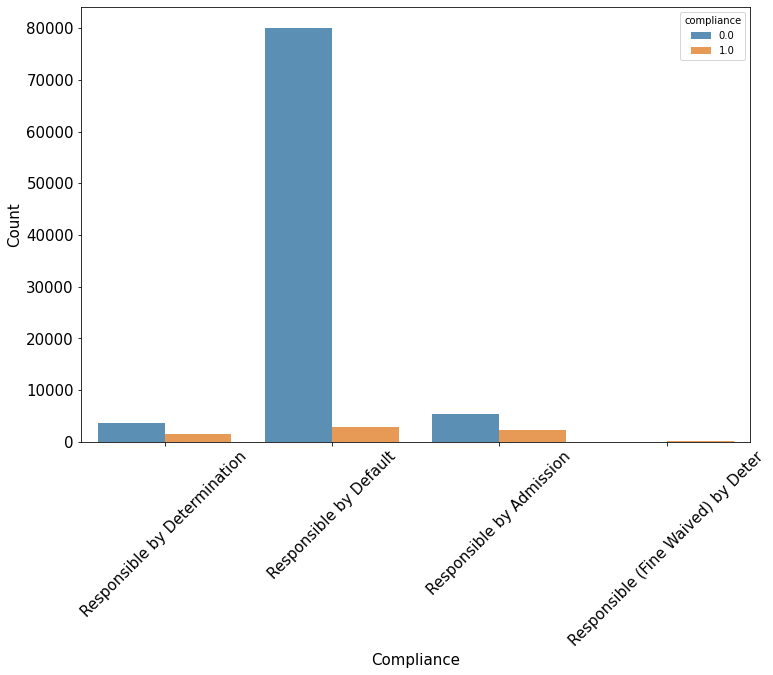

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=train_df,x='disposition',hue='compliance',alpha=0.8)
plt.xlabel('Compliance',size=15)
plt.ylabel('Count',size=15)
plt.xticks(rotation=45,size=15)
plt.yticks(size=15)
plt.show()

In [ ]:
disposition_group = train_df[['disposition','compliance','fine_amount']].groupby(['disposition','compliance']).count()
disposition_group.columns = ['count']
disposition_group['percent'] = disposition_group.groupby(level=0).apply(lambda x: 100*(x/x.sum()))
disposition_group

count     percent
disposition                        compliance                   
Responsible (Fine Waived) by Deter 1.0           136  100.000000
Responsible by Admission           0.0          5444   70.940839
                                   1.0          2230   29.059161
Responsible by Default             0.0         80046   96.437478
                                   1.0          2957    3.562522
Responsible by Determination       0.0          3669   70.720894
                                   1.0          1519   29.279106

It's a similar case with the disposition variable where there doesn't seem to be an obvious distinction between compliances across each categories. 

### 5.2 Numerical variables

In [ ]:
train_df.columns

Index(['agency_name', 'ticket_issued_date', 'hearing_date', 'disposition',
       'fine_amount', 'admin_fee', 'state_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'compliance'],
      dtype='object')

Text(0.5, 1.0, 'Fine amount vs compliance (zoomed in)')

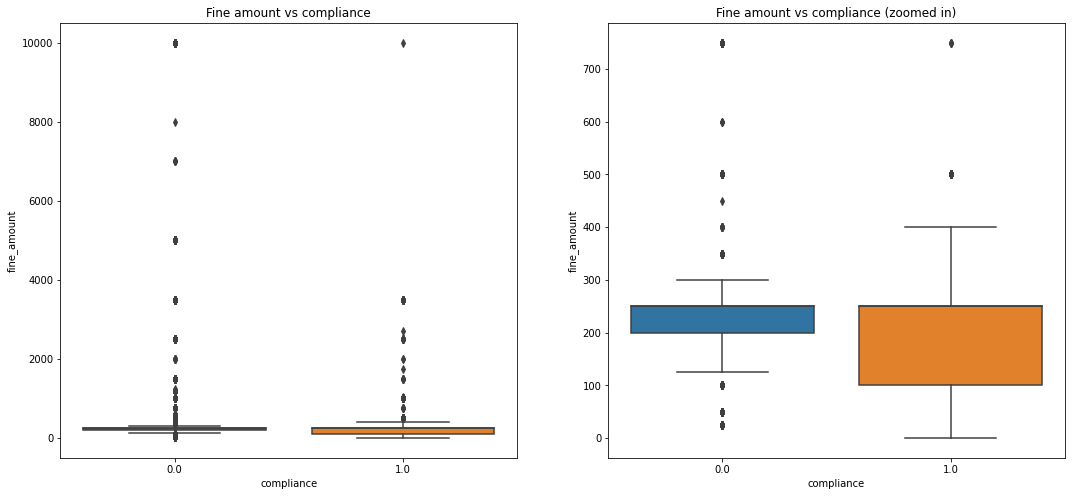

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='fine_amount',x='compliance')
plt.title('Fine amount vs compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['fine_amount']<1000],y='fine_amount',x='compliance')
plt.title('Fine amount vs compliance (zoomed in)')

Plotting compliance across the fine_amount variable shows somewhat of a distinction where the median amount for compliance is lower than that of non-compliance. 

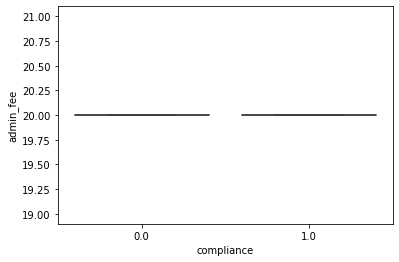

In [ ]:
sns.boxplot(data=train_df,y='admin_fee',x='compliance')

(array([    0.,     0.,     0.,     0.,     0., 96001.,     0.,     0.,
            0.,     0.]),
 array([19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4, 20.5]),
 <a list of 10 Patch objects>)

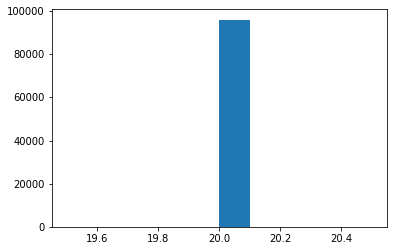

In [ ]:
plt.hist(train_df['admin_fee'])

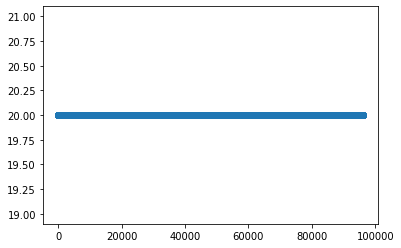

In [ ]:
plt.scatter(range(len(train_df['admin_fee'])),train_df['admin_fee'])

All the admin fees have a value of 20 so this variable doesn't provide much useful information for prediction. 

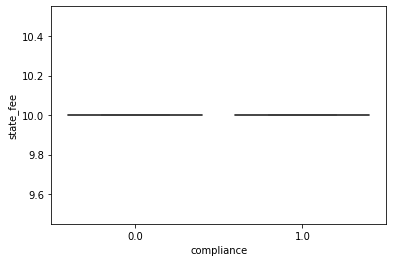

In [ ]:
sns.boxplot(data=train_df,y='state_fee',x='compliance')

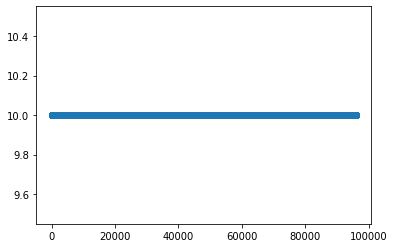

In [ ]:
plt.scatter(range(len(train_df['state_fee'])),train_df['state_fee'])

Same issue as admin fee. 

Text(0.5, 1.0, 'Discount amount vs compliance (zoomed in)')

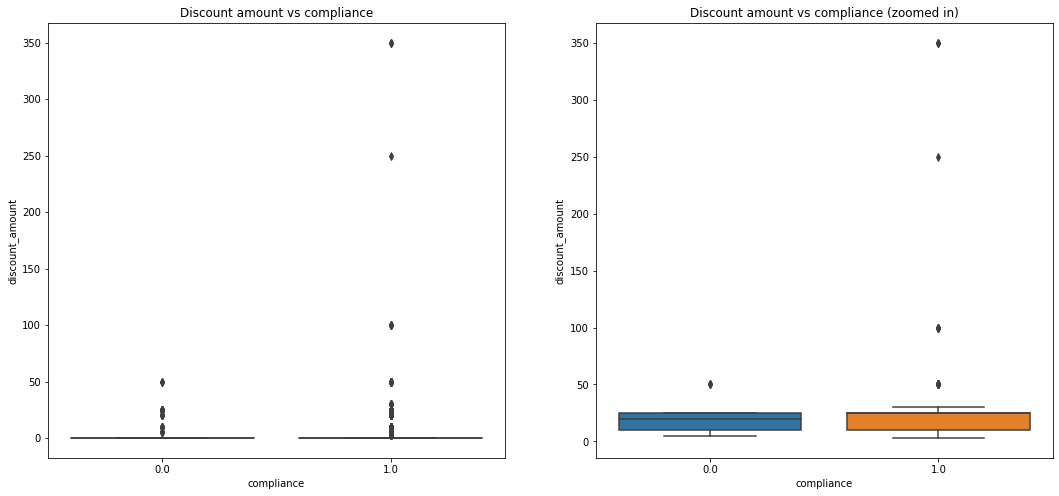

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='discount_amount',x='compliance')
plt.title('Discount amount vs compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['discount_amount']!=0],y='discount_amount',x='compliance')
plt.title('Discount amount vs compliance (zoomed in)')

Barely any distinction can be made across compliance for the discount amount variable. 

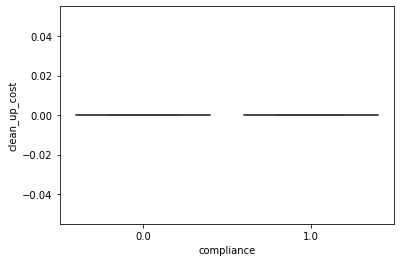

In [ ]:
sns.boxplot(data=train_df,y='clean_up_cost',x='compliance')

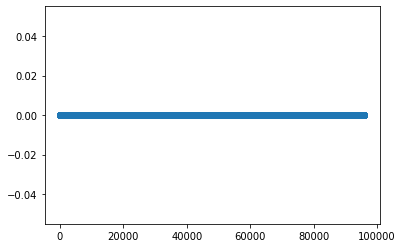

In [ ]:
plt.scatter(range(len(train_df['clean_up_cost'])),train_df['clean_up_cost'])

We can get rid of the clean up cost variable as well as it only contains one value. 

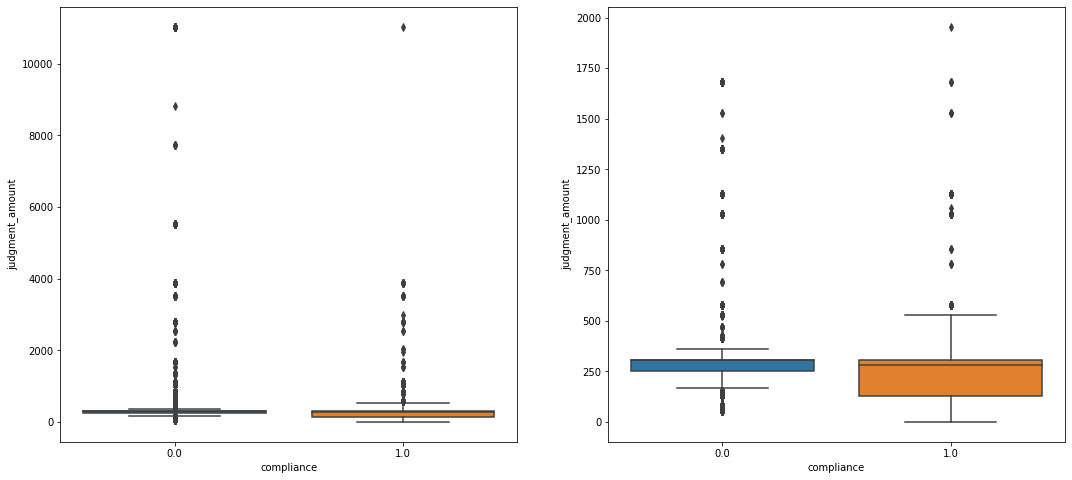

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='judgment_amount',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['judgment_amount']<2000],y='judgment_amount',x='compliance')

In [ ]:
train_df[['compliance','judgment_amount']].groupby(['compliance']).agg({'count','mean','median','std'})

judgment_amount                          
                      mean median  count         std
compliance                                          
0.0             394.490259  305.0  89159  677.460687
1.0             256.389871  280.0   6842  305.345222

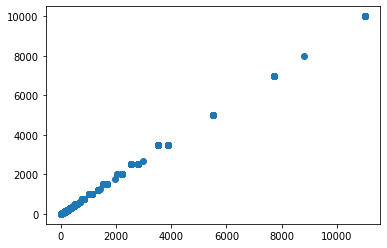

In [ ]:
plt.scatter(train_df['judgment_amount'],train_df['fine_amount'])

In [ ]:
np.corrcoef(train_df['judgment_amount'],train_df['fine_amount'])

array([[1.        , 0.99990275],
       [0.99990275, 1.        ]])

The variable *fine_amount* and *judgement_amount* are highly correlated and keeping both variables may not provide a lot more information to the model. 

# 5. Data pre-processing

### 5.1 Feature selection

Based on the EDA, variables such as *admin_fee*, *state_fee* and *clean_up_cost* are removed since they have the same values for all observations and hence are not useful for distinguishing between the target variable categories. 

In [ ]:
#Dropping fee variables that don't provide much info
train_df = train_df.drop(['admin_fee','state_fee','clean_up_cost'],axis=1)
test_df = test_df.drop(['admin_fee','state_fee','clean_up_cost'],axis=1)
train_df.head()

,agency_name,ticket_issued_date,hearing_date,disposition,fine_amount,discount_amount,judgment_amount,compliance
1,"Buildings, Safety Engineering & Env Department",2004-04-23 12:30:00,2005-05-06 13:30:00,Responsible by Determination,750.0,0.0,855.0,1.0
7,"Buildings, Safety Engineering & Env Department",2004-06-16 12:30:00,2005-02-22 15:00:00,Responsible by Default,100.0,0.0,140.0,0.0
8,"Buildings, Safety Engineering & Env Department",2004-06-16 12:25:00,2005-02-22 15:00:00,Responsible by Default,100.0,0.0,140.0,0.0
9,"Buildings, Safety Engineering & Env Department",2004-07-12 13:30:00,2005-05-31 13:30:00,Responsible by Default,750.0,0.0,855.0,0.0
12,"Buildings, Safety Engineering & Env Department",2004-07-28 12:15:00,2005-02-22 15:00:00,Responsible by Default,750.0,0.0,855.0,0.0


### 5.2 Feature engineering

Below we create a new variable called *time_to_hearing* which captures the time difference in days between the hearing date and the date on which the ticket was issued. 

In [ ]:
#Creating a new variable for storing the time difference between the ticket issued date and hearing date
#and converting the difference into days for easier calculation
train_df["ticket_issued_date"] = train_df.apply(lambda x: pd.to_datetime(x[1]),axis=1)
train_df["hearing_date"] = train_df.apply(lambda x: pd.to_datetime(x[2]),axis=1)
test_df["ticket_issued_date"] = test_df.apply(lambda x: pd.to_datetime(x[1]),axis=1)
test_df["hearing_date"] = test_df.apply(lambda x: pd.to_datetime(x[2]),axis=1)
train_df["time_to_hearing"] = train_df["hearing_date"] - train_df["ticket_issued_date"]
test_df["time_to_hearing"] = test_df["hearing_date"] - test_df["ticket_issued_date"]

test_df["time_to_hearing"] = test_df["time_to_hearing"].map(str)
test_df["time_to_hearing"] = test_df["time_to_hearing"].replace('NaT',str(pd.Timestamp('1/1/18')-pd.Timestamp('1/1/18')))
test_df["time_to_hearing"] = test_df["time_to_hearing"].map(pd.Timedelta)

train_df["time_to_hearing"] = train_df["time_to_hearing"].apply(lambda x: x.days)
test_df["time_to_hearing"] = test_df["time_to_hearing"].apply(lambda x: x.days)

In [ ]:
print (train_df.head())
print (train_df.shape)

                                       agency_name  ... time_to_hearing
1   Buildings, Safety Engineering & Env Department  ...           378.0
7   Buildings, Safety Engineering & Env Department  ...           251.0
8   Buildings, Safety Engineering & Env Department  ...           251.0
9   Buildings, Safety Engineering & Env Department  ...           323.0
12  Buildings, Safety Engineering & Env Department  ...           209.0

[5 rows x 9 columns]
(96001, 9)


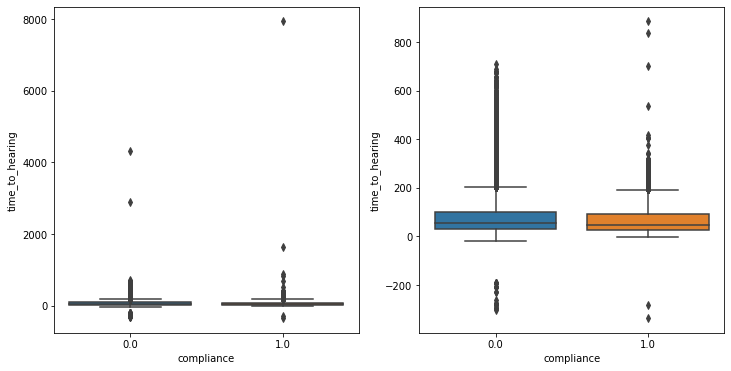

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.boxplot(data=train_df,y='time_to_hearing',x='compliance')
plt.subplot(1,2,2)
sns.boxplot(data=train_df[train_df['time_to_hearing']<1000],y='time_to_hearing',x='compliance')

In [ ]:
train_df[['compliance','time_to_hearing']].groupby(['compliance']).agg({'count','mean'})

time_to_hearing       
                      mean  count
compliance                       
0.0              72.603719  89121
1.0              71.551530   6763

### 5.3 Handling missing values

Next, we drop any observations with missing values from the dataset. We also drop the *ticket_issued_date* and *hearing_date* variables as we no longer need them. 

In [ ]:
#Dropping all the 'Nan' instances from the training set
train_df = train_df.dropna()

#Removing original time variables
train_df = train_df.drop(["ticket_issued_date","hearing_date"],axis=1)
test_df = test_df.drop(["ticket_issued_date","hearing_date"],axis=1)

### 5.4 Label encoding

Here, we label encode the categorical variables. 

In [ ]:
#Label encoding categorical variables
le = LabelEncoder()
ohe = OneHotEncoder()

le.fit(train_df["agency_name"].append(test_df["agency_name"]))
train_df["agency_name"] = le.transform(train_df["agency_name"])
test_df["agency_name"] = le.transform(test_df["agency_name"])

le.fit(train_df["disposition"].append(test_df["disposition"]))
train_df["disposition"] = le.transform(train_df["disposition"])
test_df["disposition"] = le.transform(test_df["disposition"])

### 5.5 Data preparation

Next, we split the training data into the explanatory and target variables, and then split the resulting data into train and test sets. 

In [ ]:
#Splitting the training dataset into features and target variables
y = train_df["compliance"]
x = train_df.drop(["compliance"],axis=1)

#Train/Test Split
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

#Normalization using MinMax scaler
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#for i in [0.1]:
#    for j in [25,30,35,40,45,50]:
#        for k in [5,6,7,8,9,10]:

print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(71913, 6)
(23971, 6)
(71913,)
(23971,)


In [ ]:
x.columns

Index(['agency_name', 'disposition', 'fine_amount', 'discount_amount',
       'judgment_amount', 'time_to_hearing'],
      dtype='object')

# 6. Modeling

Below, we create a function to automate the modeling, prediction and diagnosis process by including the following crucial steps: 


1.   Modeling
2.   Prediction
2.   Calculating prediction probalities
3.   Calculating scoring metrics such as accuracy, ROC AUC etc. 
5.   Visualizing confusion matrix
6.   Plotting ROC AUC 
7.   Displaying most important predictor variables


In [ ]:
#Defining lists for scoring metrics which will be used to store metrics for each modeling iteration
prec = [] 
rec = [] 
acc = [] 
auc = []
f1 = [] 
model_method = [] 
spec = []

Below, three important functions are defined which will be helpful during the modeling and diagnostics process: 
- Modeling pipeline for Logistic Regression
- Modeling pipeline for tree-based models
- Confusion matrix plotting function

In [ ]:
def model_predict_logreg(model,x_train,x_test,y_train,y_test):  
  '''
  x_train = pd.DataFrame(x_train)
  x_train.columns = x.columns
  x_test = pd.DataFrame(x_test)
  x_test.columns = x.columns
  y_train = pd.DataFrame(y_train)
  y_train.columns = 'compliance'
  y_test = pd.DataFrame(y_test)
  y_test.columns = 'compliance'
  '''
  #Modeling and prediction
  model = model.fit(x_train,y_train)
  prediction = model.predict(x_test)

  #Calculating prediction probabilities
  lr_probs = model.predict_proba(x_test)
  lr_probs_pos = lr_probs[:,1]
  lr_probs_neg = lr_probs[:,0]

  #Calculating ROC AUC values
  lr_auc = roc_auc_score(y_test, prediction)
  lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
  lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

  print('Combined ROC AUC=%.3f' % (lr_auc))
  print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
  print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

  lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
  lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
  lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)

  tn, fp, fn, tp = confusion_matrix(y_test.values, prediction).ravel()

  #Calculating scoring metrics
  precision = precision_score(y_test.values,prediction)
  accuracy = accuracy_score(y_test.values,prediction)
  roc_auc = lr_auc_pos
  recall = recall_score(y_test.values,prediction)
  f1 = f1_score(y_test.values,prediction)
  specificity = tn/(tn+fp)

  print ("ROC AUC: ",roc_auc)
  print ("Accuracy: ",accuracy)
  print ("Precision: ",precision)
  print ("Recall: ",recall)
  print ("F1 score: ",f1)
  print ("Specificity: ",specificity)

  #Plotting ROC AUC curve
  plt.figure(figsize=(9,7))
  # plot the roc curve for the model
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
  plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
  plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  # calculate precision-recall curve
  precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
  plt.figure(figsize=(9,7))
  plt.plot(recall_curve,precision_curve)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.show()

  #Plotting confusion matrix
  plot_confusion_matrix(cm           = np.array([[ tp,  fn],
                                                [  fp, tn]]), 
                        normalize    = False,
                        target_names = ['Compliance', 'Non-compliance'],
                        title        = "Confusion Matrix")
  
  return precision,recall,accuracy,roc_auc,f1,specificity

In [ ]:
def model_predict(model,x_train,x_test,y_train,y_test):  

  x_train = pd.DataFrame(x_train)
  x_train.columns = x.columns
  x_test = pd.DataFrame(x_test)
  x_test.columns = x.columns
  y_train = pd.DataFrame(y_train)
  #y_train.columns = 'compliance'
  y_test = pd.DataFrame(y_test)
  #y_test.columns = 'compliance'

  #Modeling and prediction
  model = model.fit(x_train,y_train)
  prediction = model.predict(x_test)

  #Calculating prediction probabilities
  lr_probs = model.predict_proba(x_test)
  lr_probs_pos = lr_probs[:,1]
  lr_probs_neg = lr_probs[:,0]

  #Calculating ROC AUC values
  lr_auc = roc_auc_score(y_test, prediction)
  lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
  lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

  print('Combined ROC AUC=%.3f' % (lr_auc))
  print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
  print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

  lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
  lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
  lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)

  tn, fp, fn, tp = confusion_matrix(y_test.values, prediction).ravel()

  #Calculating scoring metrics
  precision = precision_score(y_test.values,prediction)
  accuracy = accuracy_score(y_test.values,prediction)
  roc_auc = lr_auc_pos
  recall = recall_score(y_test.values,prediction)
  f1 = f1_score(y_test.values,prediction)
  specificity = tn/(tn+fp)

  print ("ROC AUC: ",roc_auc)
  print ("Accuracy: ",accuracy)
  print ("Precision: ",precision)
  print ("Recall: ",recall)
  print ("F1 score: ",f1)
  print ("Specificity: ",specificity)

  #Plotting ROC AUC curve
  plt.figure(figsize=(9,7))
  # plot the roc curve for the model
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
  plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
  plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  # calculate precision-recall curve
  precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
  plt.figure(figsize=(9,7))
  plt.plot(recall_curve,precision_curve)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.show()

  #Plotting confusion matrix
  plot_confusion_matrix(cm           = np.array([[ tp,  fn],
                                                [  fp, tn]]), 
                        normalize    = False,
                        target_names = ['Compliance', 'Non-compliance'],
                        title        = "Confusion Matrix")
  
  #model.n_features_
  #model.best_score_
  #model.booster_
  features = pd.DataFrame()
  features['Feature'] = x_train.columns
  features['Importance'] = model.feature_importances_
  print (features.sort_values('Importance',ascending=False))

  plt.figure(figsize=(12,8))
  sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
  plt.xticks(rotation=45,size=18)
  plt.yticks(size=18)
  plt.xlabel('Feature',size=20)
  plt.ylabel('Score',size=20)
  plt.show()

  return precision,recall,accuracy,roc_auc,f1,specificity

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 6.1 Baseline model - Logistic regression

We created our baseline model using a simple logistic regression model. An additional preprocessing step was included which applies **one hot encoding** to the categorical variables which is crucial for linear models. 

Also, the explanatory variables were normalized using the min max scaler to scale all the data equally which once again helps in a linear model. 

In [ ]:
x_train_preprocessed = pd.get_dummies(x_train,columns=['disposition','agency_name'])
x_test_preprocessed = pd.get_dummies(x_test,columns=['disposition','agency_name'])

x_train_preprocessed.head()

,fine_amount,discount_amount,judgment_amount,time_to_hearing,disposition_1,disposition_4,disposition_5,disposition_6,agency_name_0,agency_name_1,agency_name_2,agency_name_3
19989,250.0,0.0,305.0,180.0,0,0,1,0,1,0,0,0
165704,50.0,0.0,85.0,144.0,0,0,1,0,0,1,0,0
178756,1000.0,0.0,1130.0,109.0,0,0,1,0,0,1,0,0
98332,200.0,0.0,250.0,40.0,0,0,1,0,0,1,0,0
64248,3500.0,0.0,3880.0,15.0,0,0,1,0,0,1,0,0


In [ ]:
#Normalization using MinMax scaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_preprocessed)
x_test_scaled = scaler.transform(x_test_preprocessed)

#### 6.1.1 With scaling and preprocessing

Combined ROC AUC=0.513
Severe class ROC AUC=0.774
Not severe class ROC AUC=0.226
ROC AUC:  0.7741428216769207
Accuracy:  0.9317508656293021
Precision:  0.9777777777777777
Recall:  0.026206075044669448
F1 score:  0.05104408352668214
Specificity:  0.9999551408577068


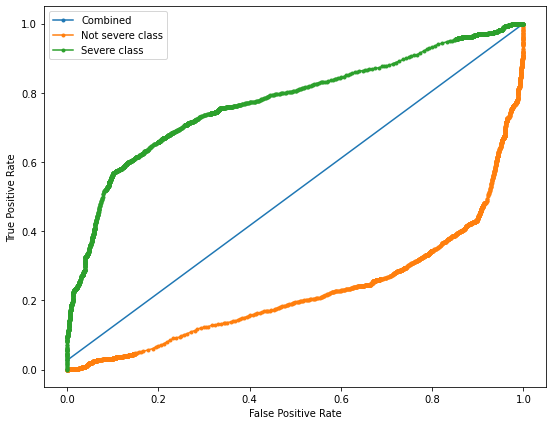

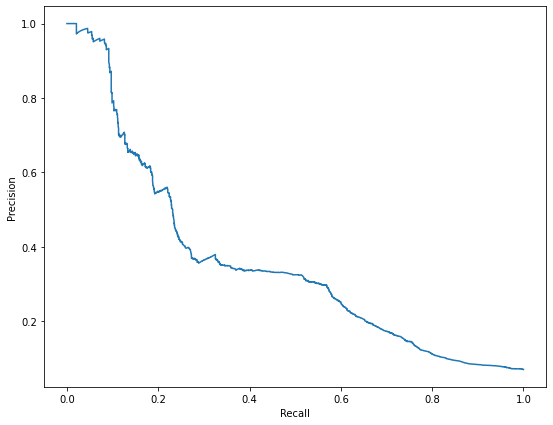

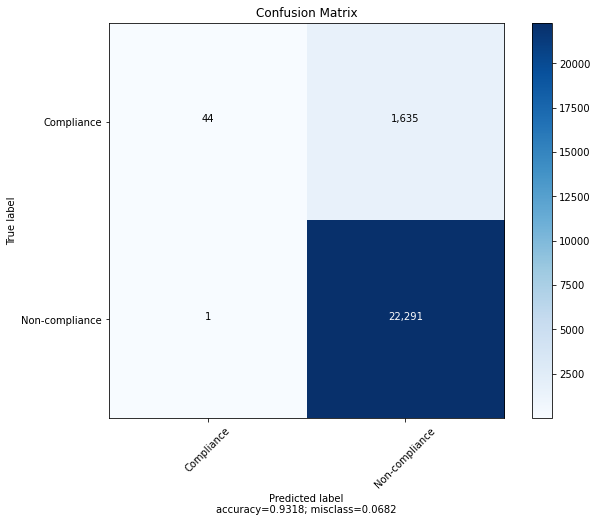

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(LogisticRegression(random_state=0,C=1),x_train_scaled,x_test_scaled,y_train,y_test)

model_method.append('baseline_logreg_with_one_hot_encoding_and_scaling')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

#### 6.1.2 With no one hot encoding or scaling

Combined ROC AUC=0.555
Severe class ROC AUC=0.779
Not severe class ROC AUC=0.221
ROC AUC:  0.7793476577649814
Accuracy:  0.9359225731091736
Precision:  0.8068669527896996
Recall:  0.11197141155449672
F1 score:  0.19665271966527195
Specificity:  0.997981338596806


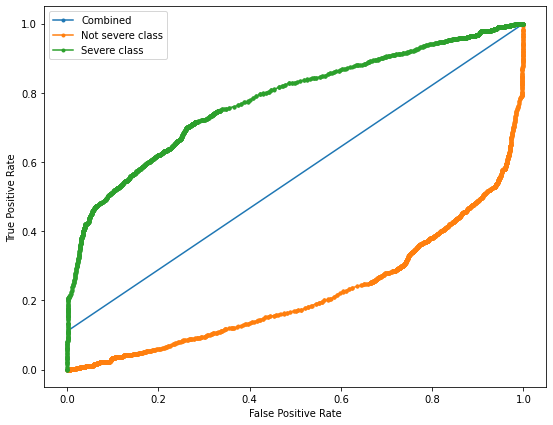

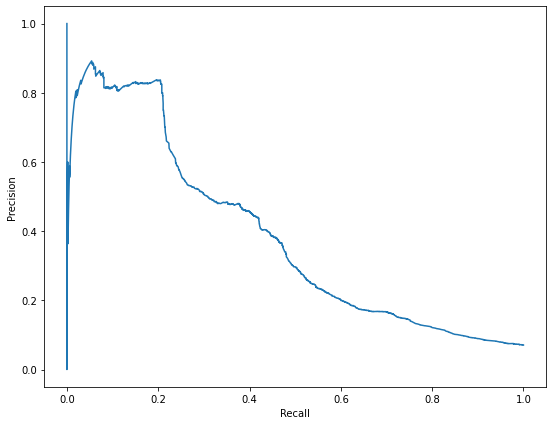

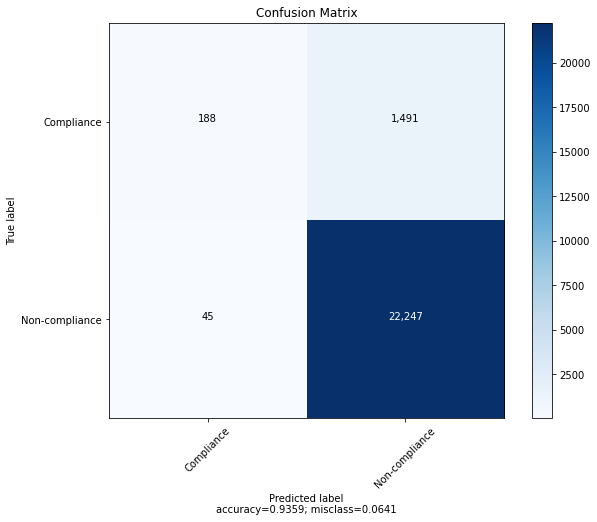

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(LogisticRegression(random_state=0,C=1),x_train,x_test,y_train,y_test)

model_method.append('baseline_logreg')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

#### 6.1.3 With one hot encoding but no scaling

Combined ROC AUC=0.573
Severe class ROC AUC=0.796
Not severe class ROC AUC=0.204
ROC AUC:  0.7962757186626963
Accuracy:  0.9390096366442785
Precision:  0.8916967509025271
Recall:  0.14711137581893985
F1 score:  0.2525562372188139
Specificity:  0.998654225731204


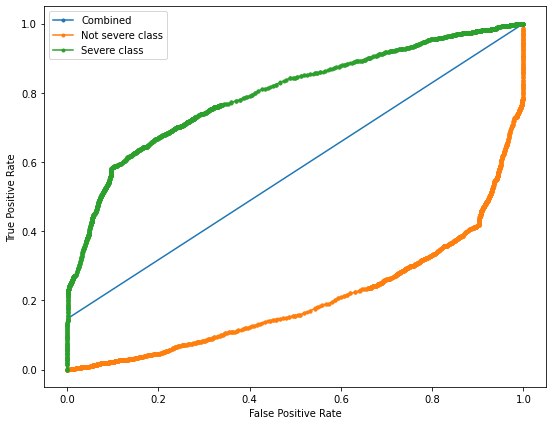

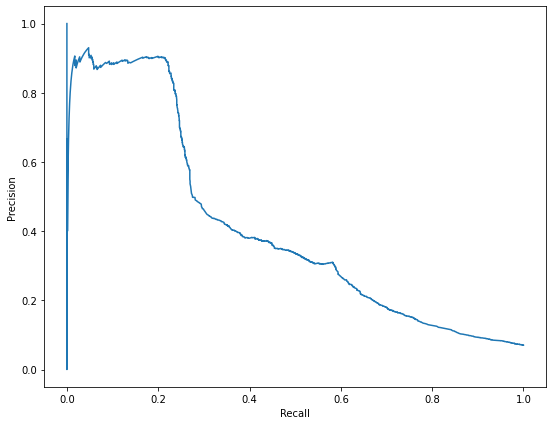

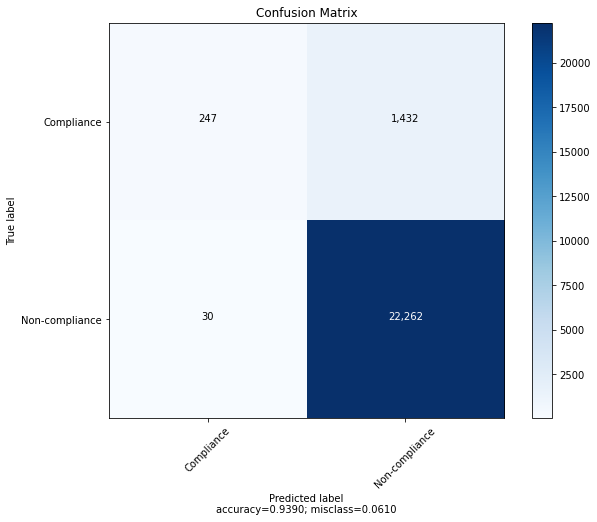

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(LogisticRegression(random_state=0,C=1),x_train_preprocessed,x_test_preprocessed,y_train,y_test)

model_method.append('baseline_logreg_only_one_hot_encoding')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

#### 6.1.4 Grid search

We use Grid Search to further optimize the Logistic Regression model to see if the results can be improved. 

In [ ]:
'''
# Create param grid
params = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear']}


# Create grid search object
clf = GridSearchCV(LogisticRegression(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_train_preprocessed, y_train)

print ("")
print ("Best estimator: ",clf.best_estimator_)
print ("Best ROC AUC score: ",clf.best_score_)
print ("Best parameters: ", clf.best_params_)
#clf.cv_results_
'''

'\n# Create param grid\nparams = {\'penalty\' : [\'l1\', \'l2\'],\n    \'C\' : np.logspace(-4, 4, 10),\n    \'solver\' : [\'liblinear\']}\n\n\n# Create grid search object\nclf = GridSearchCV(LogisticRegression(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring=\'roc_auc\')\n\n# Fit data\nbest_clf = clf.fit(x_train_preprocessed, y_train)\n\nprint ("")\nprint ("Best estimator: ",clf.best_estimator_)\nprint ("Best ROC AUC score: ",clf.best_score_)\nprint ("Best parameters: ", clf.best_params_)\n#clf.cv_results_\n'

Combined ROC AUC=0.549
Severe class ROC AUC=0.794
Not severe class ROC AUC=0.206
ROC AUC:  0.7944538336639033
Accuracy:  0.9359642901839723
Precision:  0.8870967741935484
Recall:  0.09827278141751042
F1 score:  0.17694369973190346
Specificity:  0.9990579580118428


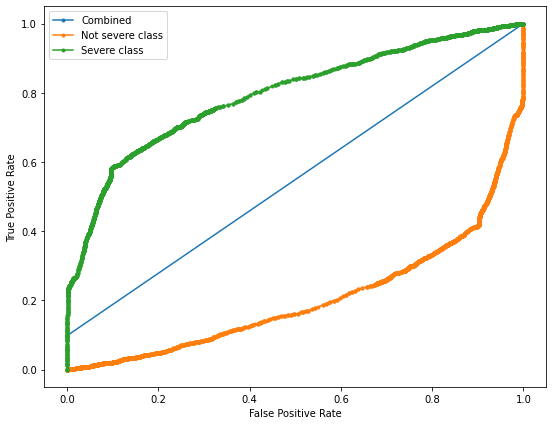

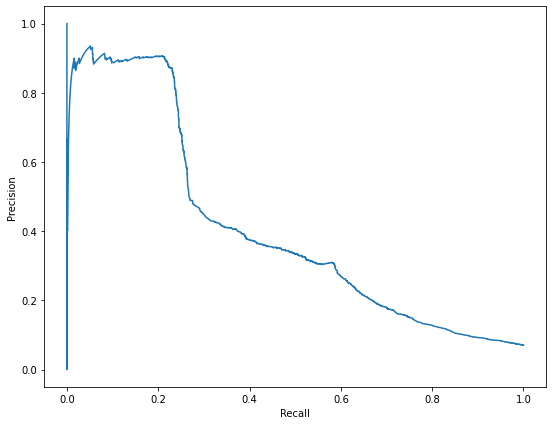

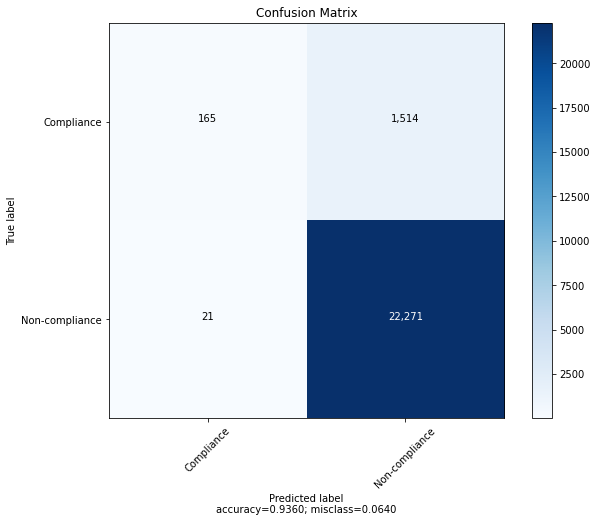

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(LogisticRegression(random_state=0,C=0.0464,solver='liblinear',penalty='l1'),x_train_preprocessed,x_test_preprocessed,y_train,y_test)

model_method.append('optimized_logreg_only_one_hot_encoding')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

## 6.1.5 Oversampled baseline Logistic Regression

In [ ]:
print (x_train.shape)
print (x_train_scaled.shape)

(71913, 6)
(71913, 12)


In [ ]:
x_resampled_logreg, y_resampled_logreg = SMOTE().fit_resample(x_train_scaled, y_train)
y_resampled_logreg = pd.Series(y_resampled_logreg)
y_resampled_logreg

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
133653    1.0
133654    1.0
133655    1.0
133656    1.0
133657    1.0
Length: 133658, dtype: float64

Combined ROC AUC=0.733
Severe class ROC AUC=0.783
Not severe class ROC AUC=0.217
ROC AUC:  0.7825872412797729
Accuracy:  0.8763088732218097
Precision:  0.29817953546767106
Recall:  0.5658129839189994
F1 score:  0.39054470709146966
Specificity:  0.8996949578324063


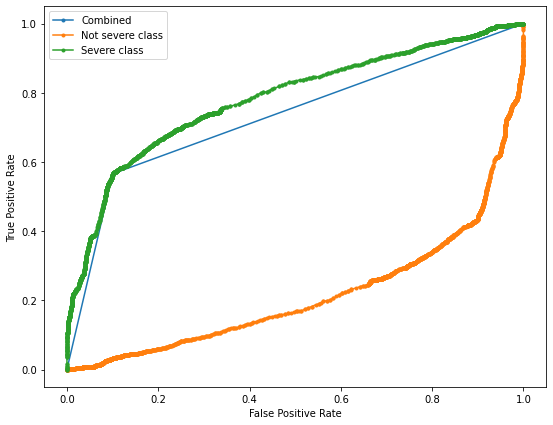

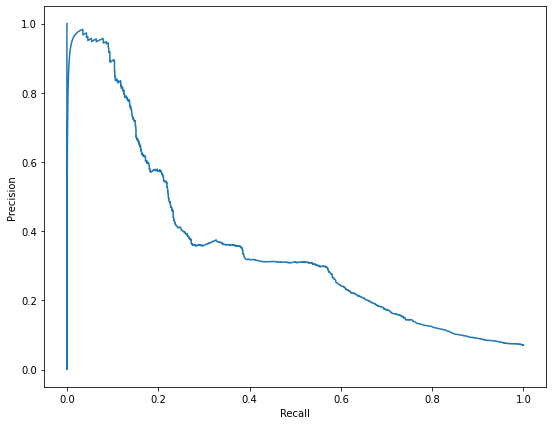

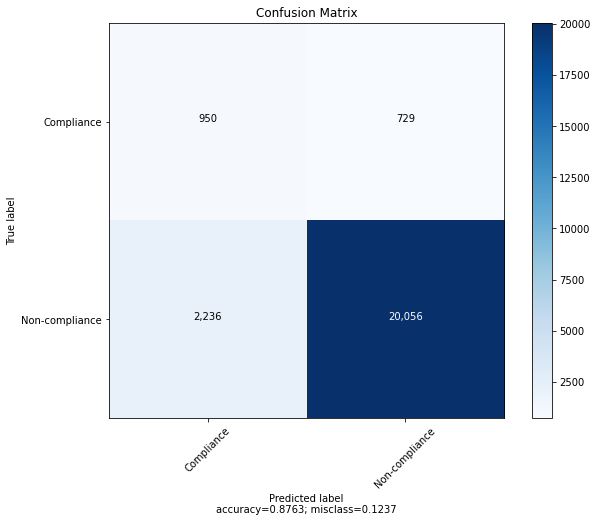

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(LogisticRegression(random_state=0,C=0.0464,solver='liblinear',penalty='l1'),x_resampled_logreg,x_test_scaled,y_resampled_logreg,y_test)

model_method.append('oversampled_optimized_logreg_only_one_hot_encoding')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

## 6.1.6 Oversampled optimized Logistic Regression

In [ ]:
'''
# Create param grid
params = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 10),
    'solver' : ['liblinear']}


# Create grid search object
clf = GridSearchCV(LogisticRegression(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_resampled_logreg, y_resampled_logreg)

print ("")
print ("Best estimator: ",clf.best_estimator_)
print ("Best ROC AUC score: ",clf.best_score_)
print ("Best parameters: ", clf.best_params_)
#clf.cv_results_
'''

'\n# Create param grid\nparams = {\'penalty\' : [\'l1\', \'l2\'],\n    \'C\' : np.logspace(-4, 4, 10),\n    \'solver\' : [\'liblinear\']}\n\n\n# Create grid search object\nclf = GridSearchCV(LogisticRegression(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring=\'roc_auc\')\n\n# Fit data\nbest_clf = clf.fit(x_resampled_logreg, y_resampled_logreg)\n\nprint ("")\nprint ("Best estimator: ",clf.best_estimator_)\nprint ("Best ROC AUC score: ",clf.best_score_)\nprint ("Best parameters: ", clf.best_params_)\n#clf.cv_results_\n'

Combined ROC AUC=0.741
Severe class ROC AUC=0.796
Not severe class ROC AUC=0.204
ROC AUC:  0.7958695283468634
Accuracy:  0.8778524049893621
Precision:  0.3049047172758513
Recall:  0.5812983918999405
F1 score:  0.39999999999999997
Specificity:  0.9001884083976315


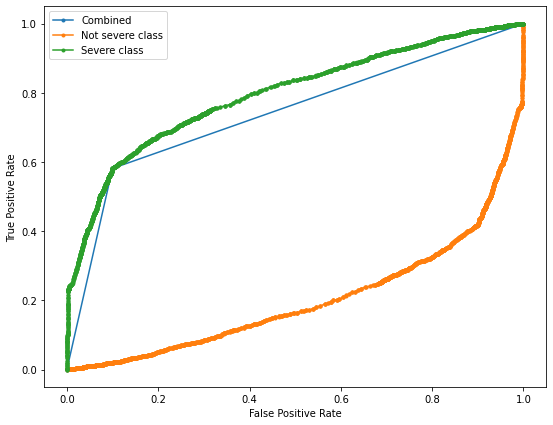

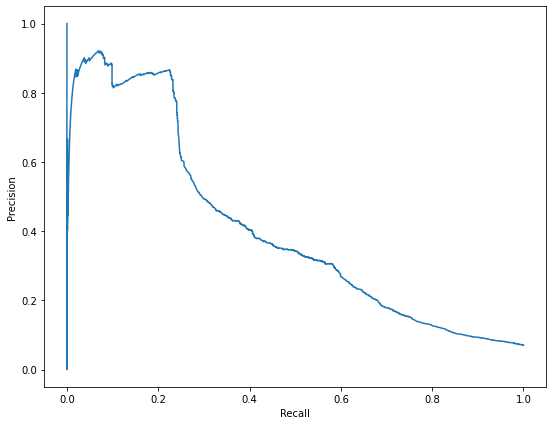

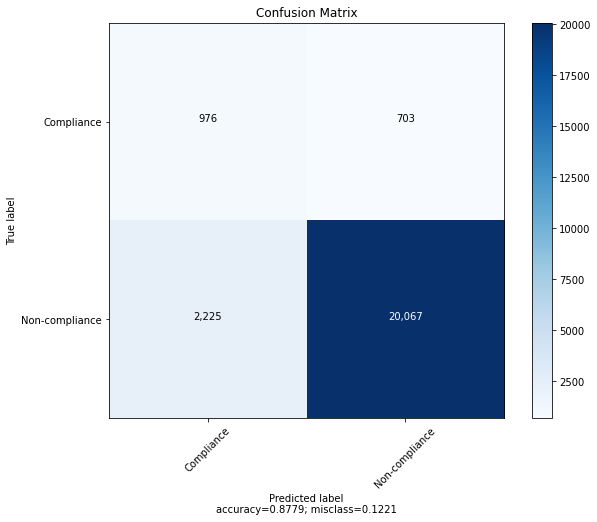

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(LogisticRegression(random_state=0,C=10000,solver='liblinear',penalty='l2'),x_resampled_logreg,x_test_scaled,y_resampled_logreg,y_test)

model_method.append('optimized_oversampled_logreg_only_one_hot_encoding')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

### 6.6 Oversampling the minority class

In [ ]:
target_var_dist = pd.DataFrame()
target_var_dist['count'] = y_train.value_counts()
target_var_dist['percent'] = target_var_dist['count'].apply(lambda x: x/target_var_dist['count'].sum())
target_var_dist

,count,percent
0.0,66829,0.929303
1.0,5084,0.070697


In [ ]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
y_resampled = pd.Series(y_resampled)
y_resampled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
133653    1.0
133654    1.0
133655    1.0
133656    1.0
133657    1.0
Length: 133658, dtype: float64

In [ ]:
target_var_dist_resampled = pd.DataFrame()
target_var_dist_resampled['count'] = y_resampled.value_counts()
target_var_dist_resampled['percent'] = target_var_dist_resampled['count'].apply(lambda x: x/target_var_dist_resampled['count'].sum())
target_var_dist_resampled

,count,percent
1.0,66829,0.5
0.0,66829,0.5


### 6.2 Decision Trees 

Since tree-based models perform better on different data types and formats, we don't need to apply one hot encoding feature scaling. 

Combined ROC AUC=0.628
Severe class ROC AUC=0.713
Not severe class ROC AUC=0.287
ROC AUC:  0.7133111262321836
Accuracy:  0.9408451879354219
Precision:  0.709470304975923
Recall:  0.26325193567599764
F1 score:  0.3840139009556907
Specificity:  0.9918804952449309


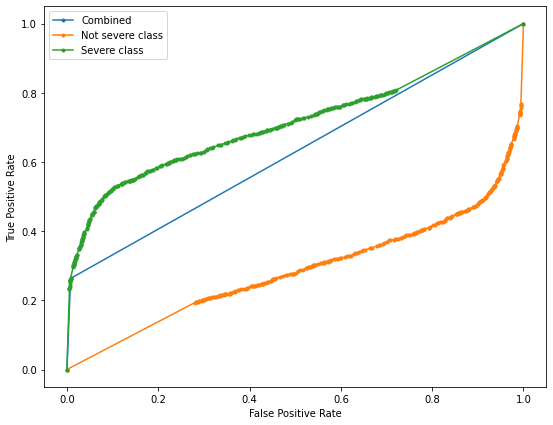

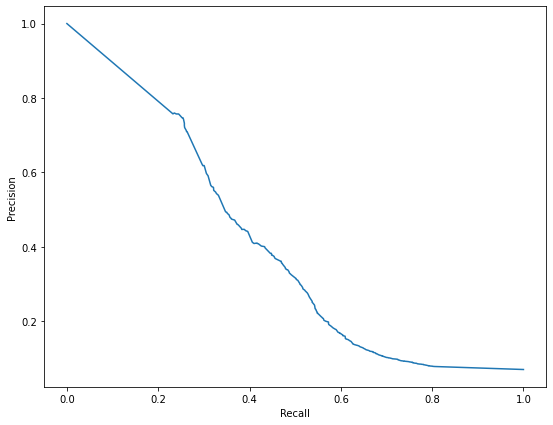

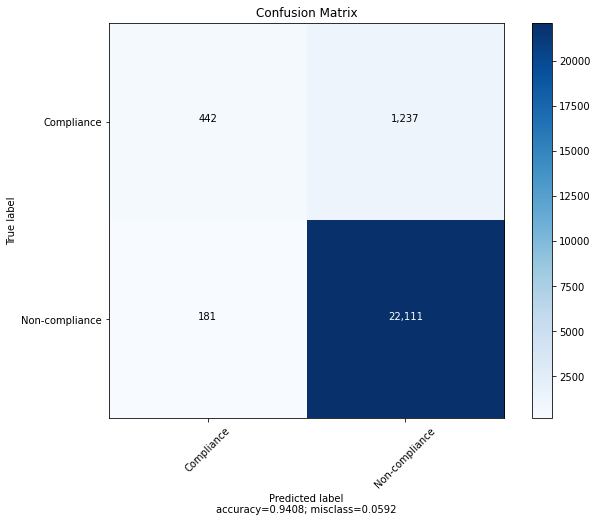

           Feature  Importance
5  time_to_hearing    0.251087
4  judgment_amount    0.243533
1      disposition    0.227810
3  discount_amount    0.191874
2      fine_amount    0.052370
0      agency_name    0.033327


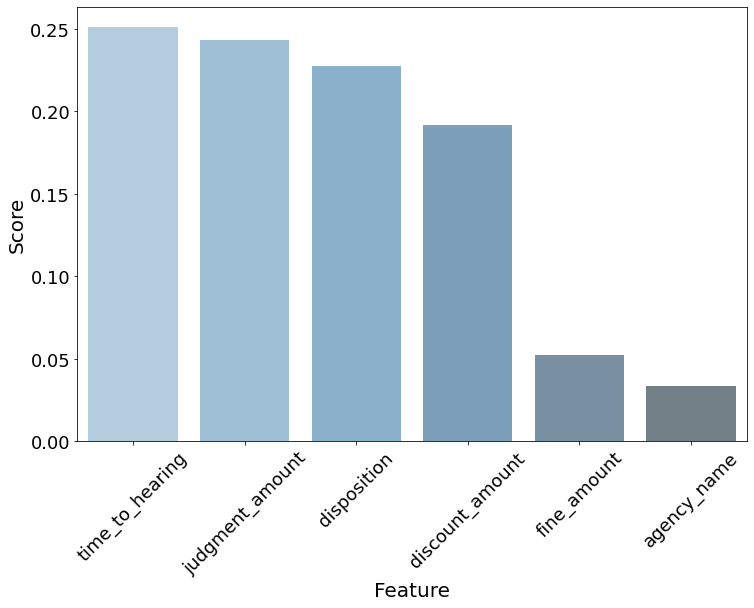

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(DecisionTreeClassifier(random_state=0),x_train,x_test,y_train,y_test)

model_method.append('baseline_decisiontrees')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

In [ ]:
'''
params = {'max_depth' : [5,10,15,20],
    'max_leaf_nodes':[30,40,50,60,70],
         #'learning_rate':[0.001,0.003,0.005,0.01],
         'min_samples_leaf':[500,1000,2000,5000,10000,50000],
         #'objective':['binary'],
         }

# Create grid search object
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_train, y_train)

print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
#clf.cv_results_
'''

"\nparams = {'max_depth' : [5,10,15,20],\n    'max_leaf_nodes':[30,40,50,60,70],\n         #'learning_rate':[0.001,0.003,0.005,0.01],\n         'min_samples_leaf':[500,1000,2000,5000,10000,50000],\n         #'objective':['binary'],\n         }\n\n# Create grid search object\nclf = GridSearchCV(DecisionTreeClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')\n\n# Fit data\nbest_clf = clf.fit(x_train, y_train)\n\nprint (clf.best_estimator_)\nprint (clf.best_score_)\nprint (clf.best_params_)\n#clf.cv_results_\n"

Combined ROC AUC=0.559
Severe class ROC AUC=0.786
Not severe class ROC AUC=0.214
ROC AUC:  0.7863978103395006
Accuracy:  0.9324183388260815
Precision:  0.5817174515235457
Recall:  0.12507444907683143
F1 score:  0.2058823529411765
Specificity:  0.993226269513727


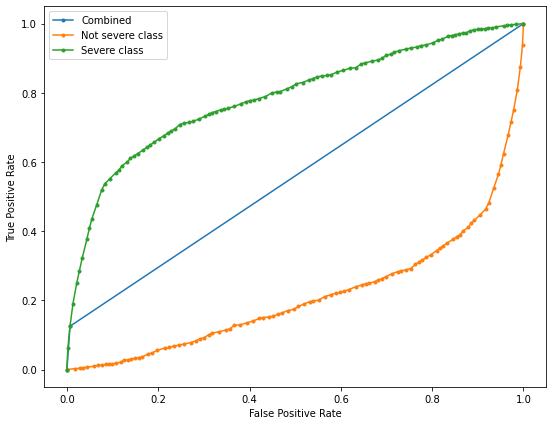

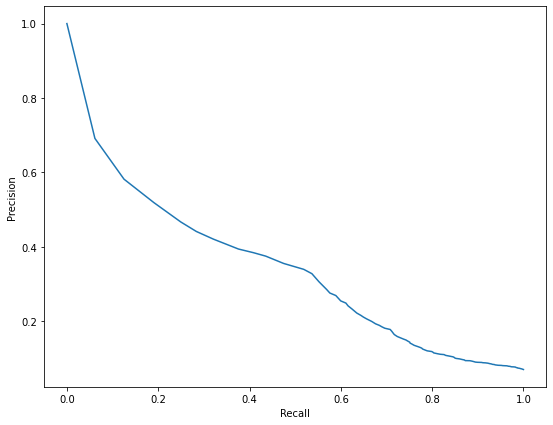

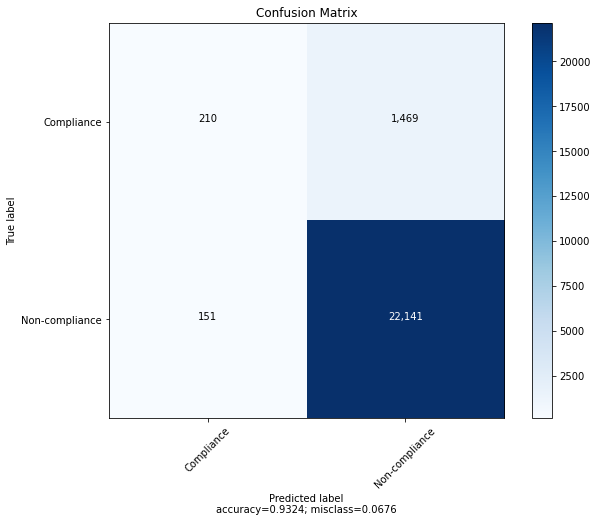

           Feature  Importance
1      disposition    0.707921
5  time_to_hearing    0.187580
4  judgment_amount    0.090941
0      agency_name    0.012670
2      fine_amount    0.000888
3  discount_amount    0.000000


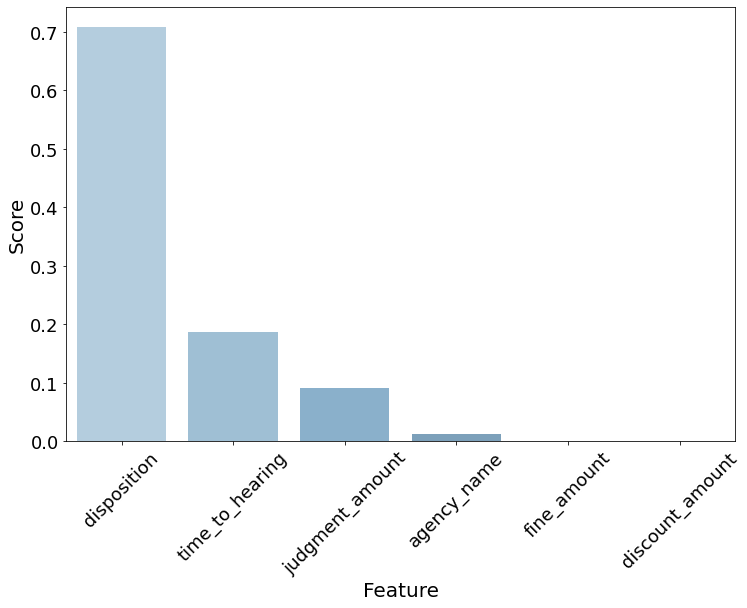

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(DecisionTreeClassifier(random_state=0,max_depth=20,min_samples_leaf=500),x_train,x_test,y_train,y_test)

model_method.append('optimized_decisiontrees')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

### 6.3 Random Forest

Combined ROC AUC=0.639
Severe class ROC AUC=0.754
Not severe class ROC AUC=0.246
ROC AUC:  0.7536380523939821
Accuracy:  0.9416378123565976
Precision:  0.7040816326530612
Recall:  0.2876712328767123
F1 score:  0.40845665961945027
Specificity:  0.9908935941144805


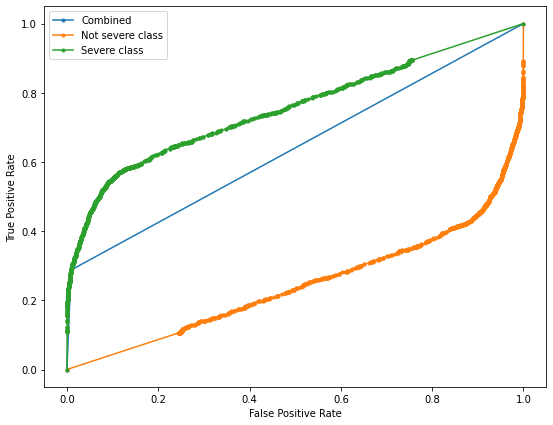

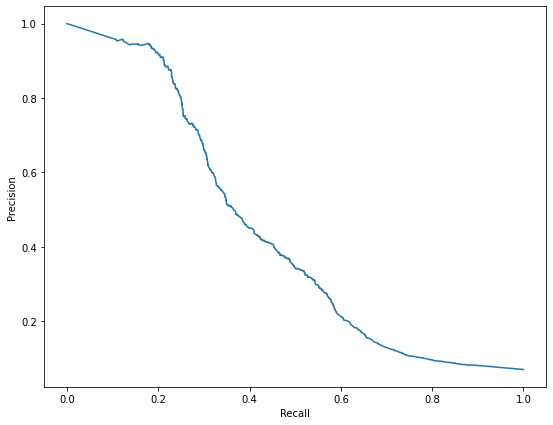

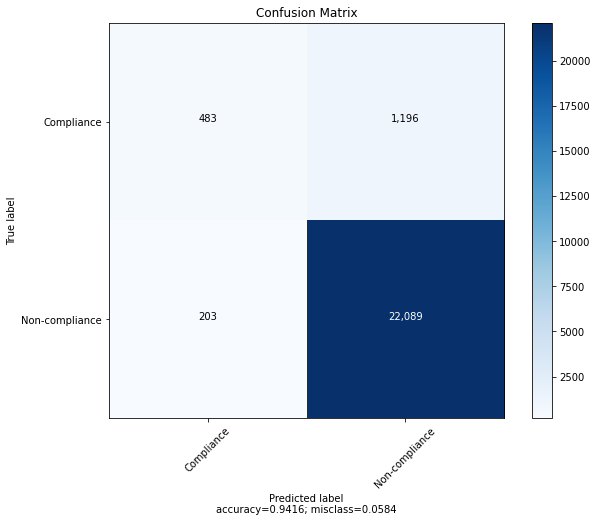

           Feature  Importance
5  time_to_hearing    0.348484
1      disposition    0.217643
4  judgment_amount    0.201186
3  discount_amount    0.118470
2      fine_amount    0.083549
0      agency_name    0.030669


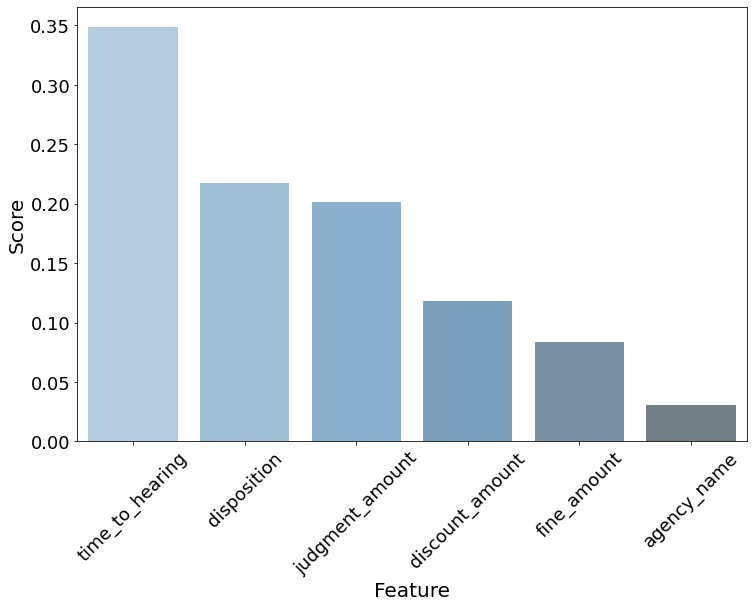

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(RandomForestClassifier(random_state=0),x_train,x_test,y_train,y_test)

model_method.append('baseline_randomforest')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

In [ ]:
'''
params = {'max_depth' : [5,10,15,20],
    #'max_leaf_nodes':[30,40,50,60,70],
    'max_features':['auto','log2',2,3],
    #'n_estimators':[50,100,200,300],
         'min_samples_leaf':[500,1000,2000,5000],
         #'objective':['binary'],
         }

# Create grid search object
clf = GridSearchCV(RandomForestClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_train, y_train)

print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
#clf.cv_results_
'''

"\nparams = {'max_depth' : [5,10,15,20],\n    #'max_leaf_nodes':[30,40,50,60,70],\n    'max_features':['auto','log2',2,3],\n    #'n_estimators':[50,100,200,300],\n         'min_samples_leaf':[500,1000,2000,5000],\n         #'objective':['binary'],\n         }\n\n# Create grid search object\nclf = GridSearchCV(RandomForestClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')\n\n# Fit data\nbest_clf = clf.fit(x_train, y_train)\n\nprint (clf.best_estimator_)\nprint (clf.best_score_)\nprint (clf.best_params_)\n#clf.cv_results_\n"

Combined ROC AUC=0.500
Severe class ROC AUC=0.795
Not severe class ROC AUC=0.205
ROC AUC:  0.7953773335170093
Accuracy:  0.9299570314129573
Precision:  0.0
Recall:  0.0
F1 score:  0.0
Specificity:  1.0


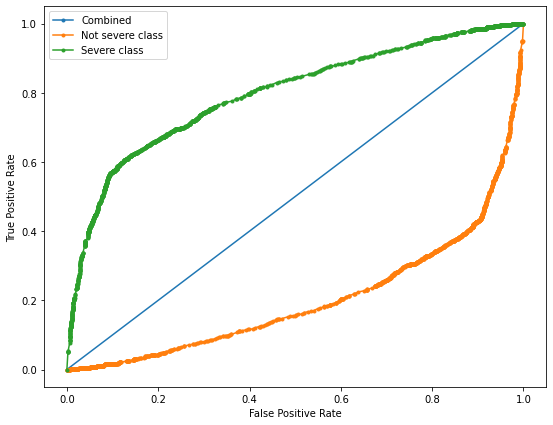

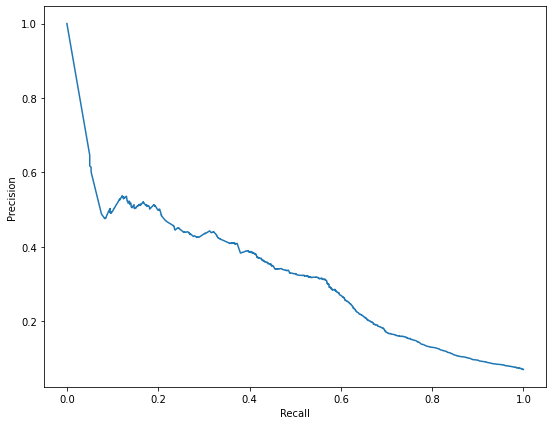

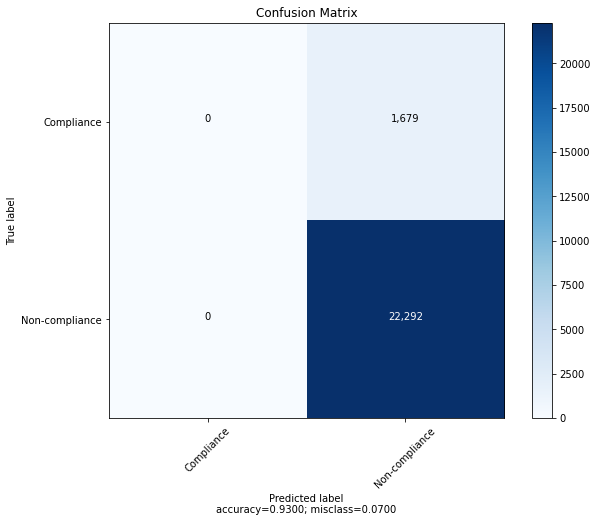

           Feature  Importance
1      disposition    0.608184
4  judgment_amount    0.234114
5  time_to_hearing    0.088123
2      fine_amount    0.048197
0      agency_name    0.021383
3  discount_amount    0.000000


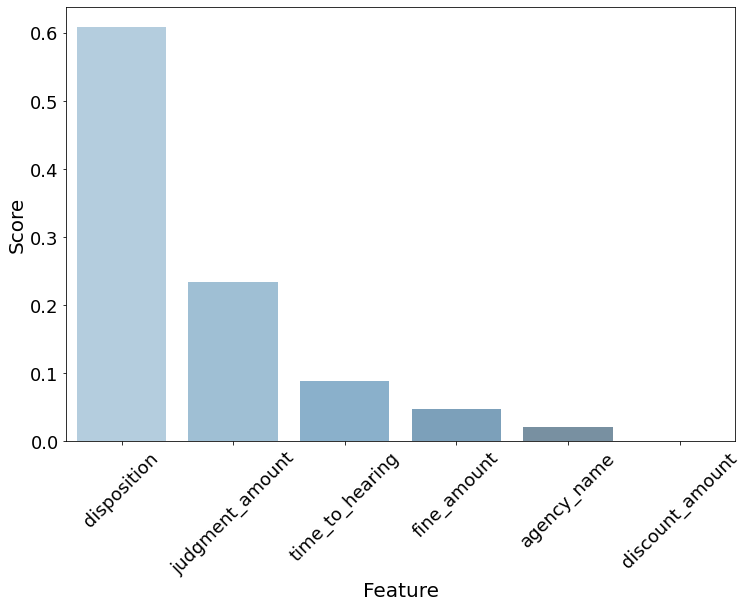

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(RandomForestClassifier(random_state=0,max_depth=15,max_features=3,min_samples_leaf=500),x_train,x_test,y_train,y_test)

model_method.append('optimized_randomforest')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

In [ ]:
'''
params = {'max_depth' : [5,10,15,20],
    #'max_leaf_nodes':[30,40,50,60,70],
    'max_features':['auto','log2',2,3],
    #'n_estimators':[50,100,200,300],
         'min_samples_leaf':[500,1000,2000,5000],
         #'objective':['binary'],
         }

# Create grid search object
clf = GridSearchCV(RandomForestClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_resampled_logreg,y_resampled_logreg)

print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
#clf.cv_results_
'''

"\nparams = {'max_depth' : [5,10,15,20],\n    #'max_leaf_nodes':[30,40,50,60,70],\n    'max_features':['auto','log2',2,3],\n    #'n_estimators':[50,100,200,300],\n         'min_samples_leaf':[500,1000,2000,5000],\n         #'objective':['binary'],\n         }\n\n# Create grid search object\nclf = GridSearchCV(RandomForestClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')\n\n# Fit data\nbest_clf = clf.fit(x_resampled_logreg,y_resampled_logreg)\n\nprint (clf.best_estimator_)\nprint (clf.best_score_)\nprint (clf.best_params_)\n#clf.cv_results_\n"

Combined ROC AUC=0.738
Severe class ROC AUC=0.802
Not severe class ROC AUC=0.198
ROC AUC:  0.801572624199442
Accuracy:  0.8707605022735806
Precision:  0.2900266350991418
Recall:  0.5836807623585467
F1 score:  0.387504942665085
Specificity:  0.8923829176386148


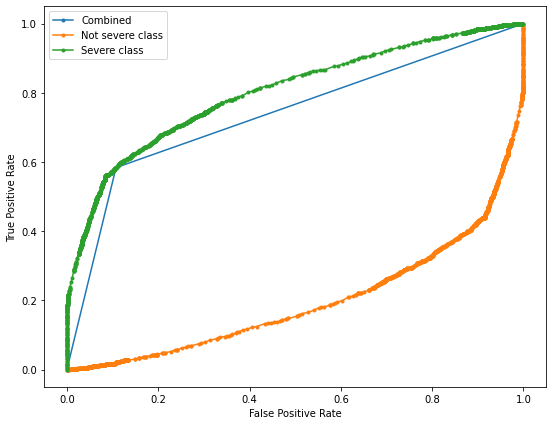

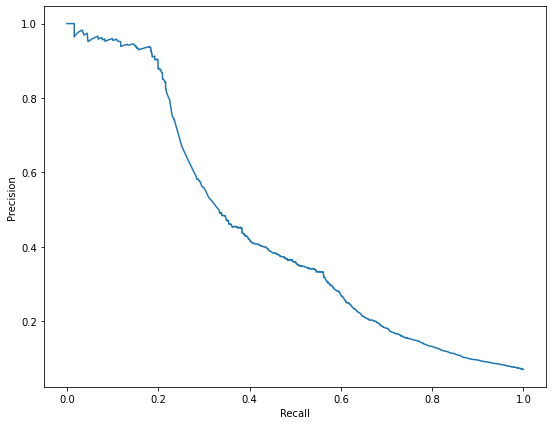

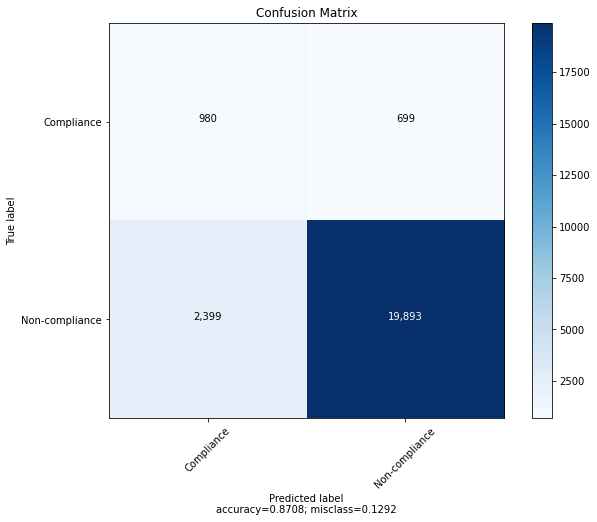

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict_logreg(RandomForestClassifier(random_state=0,max_depth=20,max_features='log2',min_samples_leaf=500),x_resampled_logreg,x_test_scaled,y_resampled_logreg,y_test)

model_method.append('optimized_oversampled_randomforest')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

With the optimized Random Forest model, we see that none of the compliance labels were predicted which is likely the effect of the class imbalance being heavily skewed towards the non-compliance labels. 

#### 6.4 Gradient Boosting

Combined ROC AUC=0.602
Severe class ROC AUC=0.804
Not severe class ROC AUC=0.196
ROC AUC:  0.8039973289707126
Accuracy:  0.9431396270493513
Precision:  0.9224598930481284
Recall:  0.2054794520547945
F1 score:  0.33609352167559664
Specificity:  0.9986990848734972


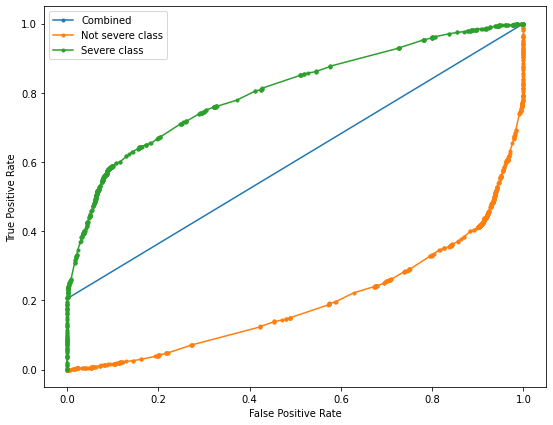

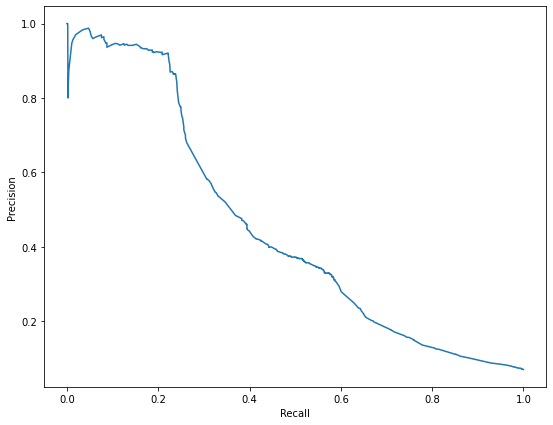

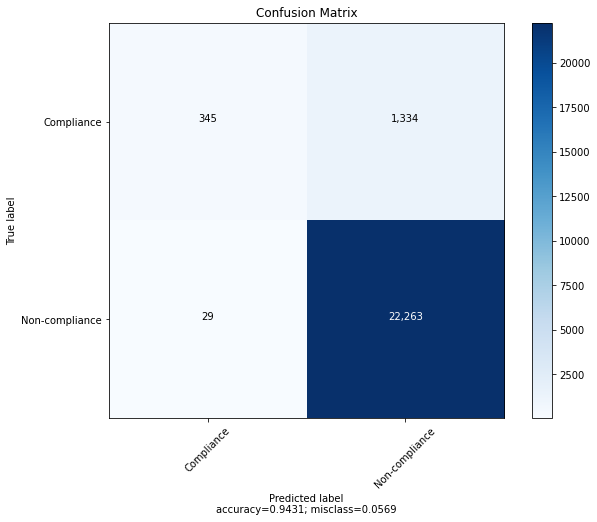

           Feature  Importance
1      disposition    0.530109
3  discount_amount    0.194557
4  judgment_amount    0.153692
2      fine_amount    0.071310
5  time_to_hearing    0.042242
0      agency_name    0.008090


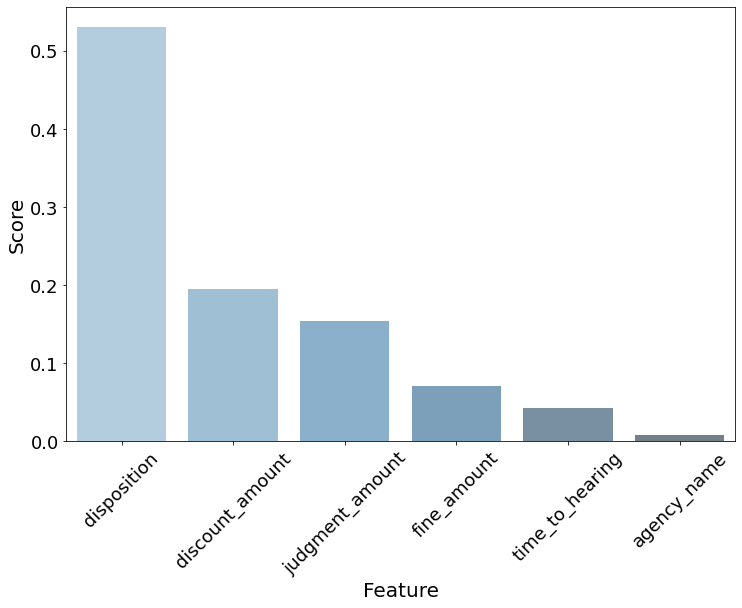

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(GradientBoostingClassifier(random_state=0),x_train,x_test,y_train,y_test)

model_method.append('baseline_gradientboosting')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

In [ ]:
'''
params = {'max_depth' : [5,10,15],
    'max_leaf_nodes':[5,10,15],
         'learning_rate':[0.001,0.01,0.1,1],
         'min_samples_leaf':[1000,2000,5000,10000,50000],
         }

# Create grid search object
clf = GridSearchCV(GradientBoostingClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_train, y_train)

print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
#clf.cv_results_
'''

"\nparams = {'max_depth' : [5,10,15],\n    'max_leaf_nodes':[5,10,15],\n         'learning_rate':[0.001,0.01,0.1,1],\n         'min_samples_leaf':[1000,2000,5000,10000,50000],\n         }\n\n# Create grid search object\nclf = GridSearchCV(GradientBoostingClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')\n\n# Fit data\nbest_clf = clf.fit(x_train, y_train)\n\nprint (clf.best_estimator_)\nprint (clf.best_score_)\nprint (clf.best_params_)\n#clf.cv_results_\n"

Combined ROC AUC=0.582
Severe class ROC AUC=0.795
Not severe class ROC AUC=0.205
ROC AUC:  0.7952288494888409
Accuracy:  0.9377164073255183
Precision:  0.743455497382199
Recall:  0.16914830256104824
F1 score:  0.27559437166424067
Specificity:  0.9956038040552665


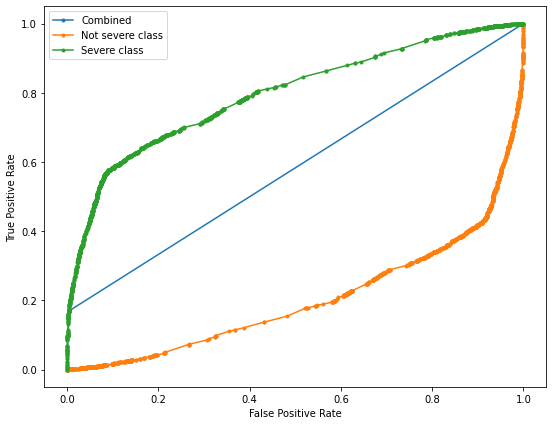

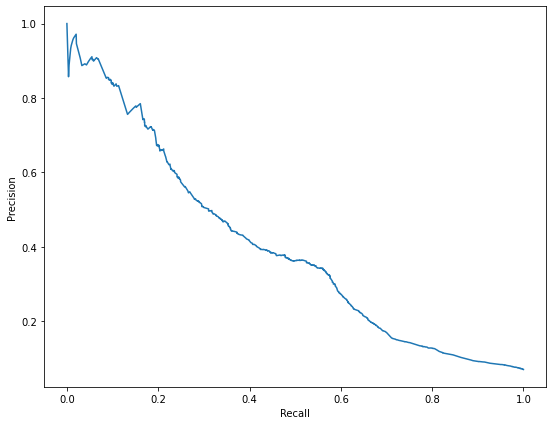

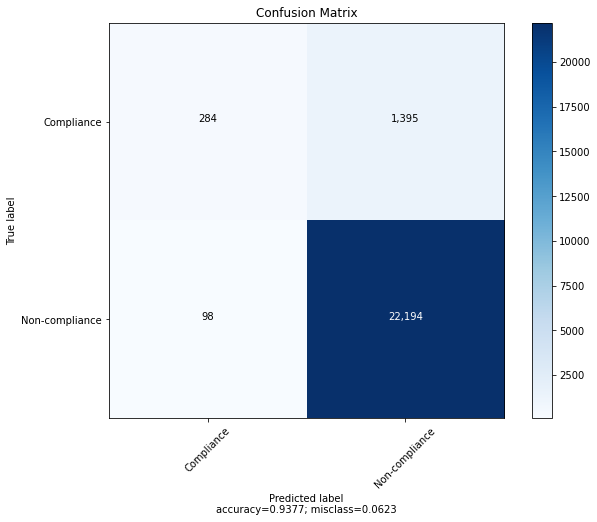

           Feature  Importance
1      disposition    0.645815
5  time_to_hearing    0.157663
4  judgment_amount    0.148473
2      fine_amount    0.025566
0      agency_name    0.022484
3  discount_amount    0.000000


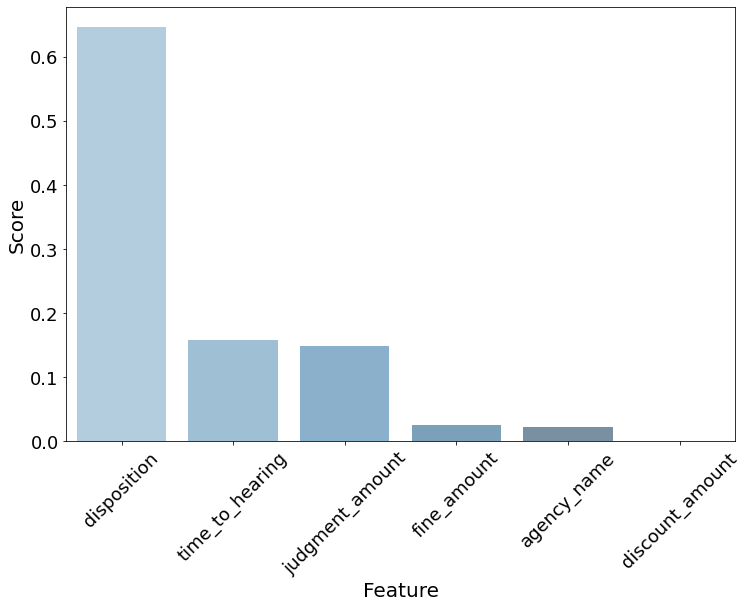

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(GradientBoostingClassifier(learning_rate=0.1,max_depth=15,max_leaf_nodes=15,min_samples_leaf=1000,random_state=0),x_train,x_test,y_train,y_test)

model_method.append('optimized_gradientboosting')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

In [ ]:
'''
params = {'max_depth' : [5,10,15],
    'max_leaf_nodes':[5,10,15],
         'learning_rate':[0.001,0.01,0.1],
         'min_samples_leaf':[500,1000,2000,3000],
         }

# Create grid search object
clf = GridSearchCV(GradientBoostingClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_resampled,y_resampled)

print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
#clf.cv_results_
'''

"\nparams = {'max_depth' : [5,10,15],\n    'max_leaf_nodes':[5,10,15],\n         'learning_rate':[0.001,0.01,0.1],\n         'min_samples_leaf':[500,1000,2000,3000],\n         }\n\n# Create grid search object\nclf = GridSearchCV(GradientBoostingClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')\n\n# Fit data\nbest_clf = clf.fit(x_resampled,y_resampled)\n\nprint (clf.best_estimator_)\nprint (clf.best_score_)\nprint (clf.best_params_)\n#clf.cv_results_\n"

Combined ROC AUC=0.734
Severe class ROC AUC=0.781
Not severe class ROC AUC=0.219
ROC AUC:  0.7810175587072317
Accuracy:  0.8930374202160944
Precision:  0.337852693294247
Recall:  0.5491363907087552
F1 score:  0.41833030852994557
Specificity:  0.9189395298761888


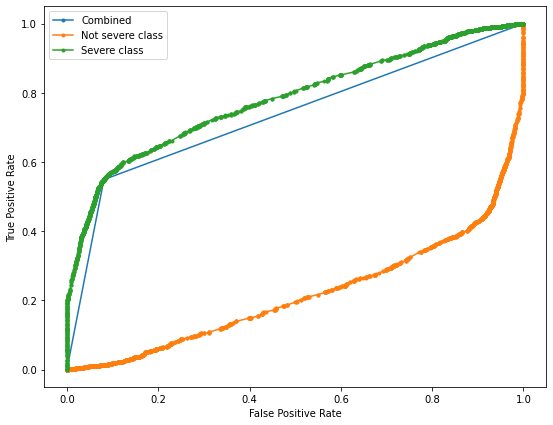

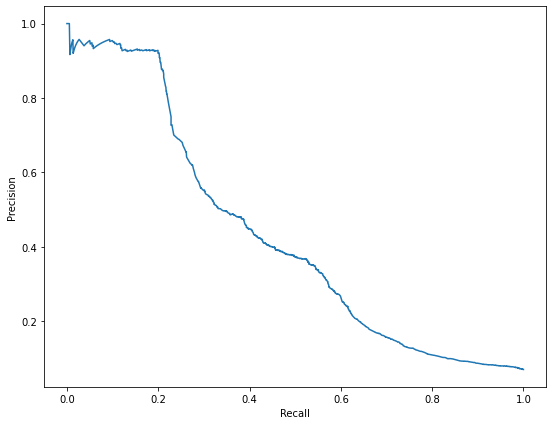

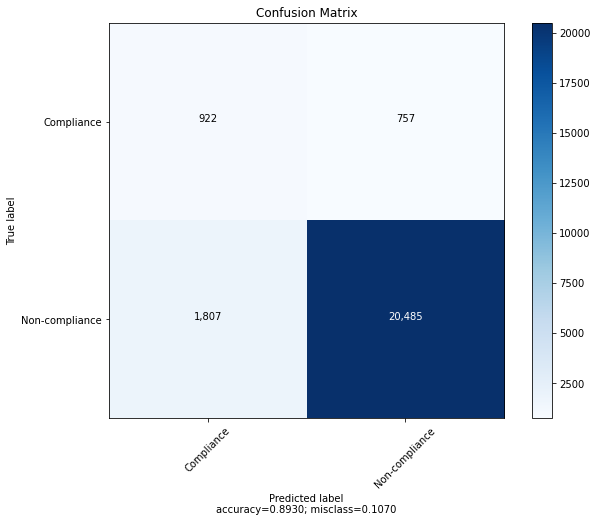

           Feature  Importance
1      disposition    0.693978
5  time_to_hearing    0.087739
0      agency_name    0.082200
4  judgment_amount    0.080748
2      fine_amount    0.043186
3  discount_amount    0.012149


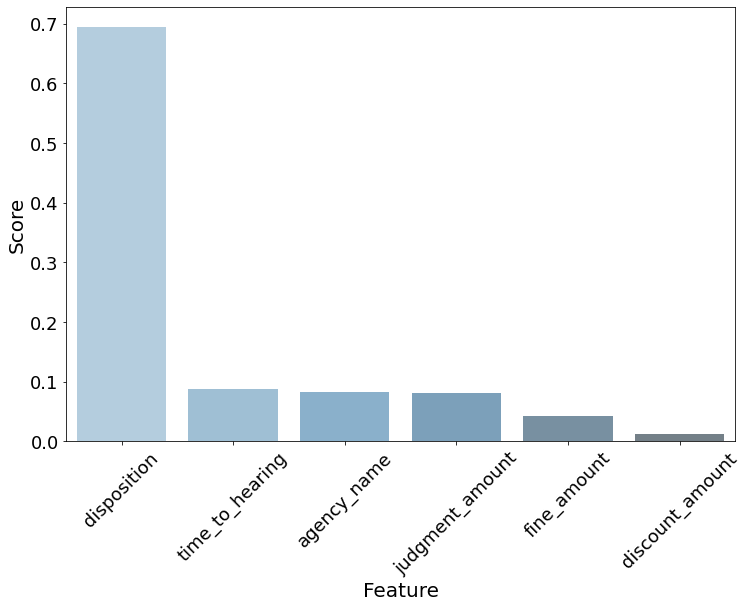

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(GradientBoostingClassifier(learning_rate=0.1,max_depth=15,max_leaf_nodes=15,min_samples_leaf=500,random_state=0),x_resampled,x_test,y_resampled,y_test)

model_method.append('optimized_oversampled_gradientboosting')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

### 6.5 LightGBM

Combined ROC AUC=0.619
Severe class ROC AUC=0.803
Not severe class ROC AUC=0.197
ROC AUC:  0.8029839906030384
Accuracy:  0.944933461265696
Precision:  0.901565995525727
Recall:  0.24002382370458605
F1 score:  0.3791157102539981
Specificity:  0.9980261977390992


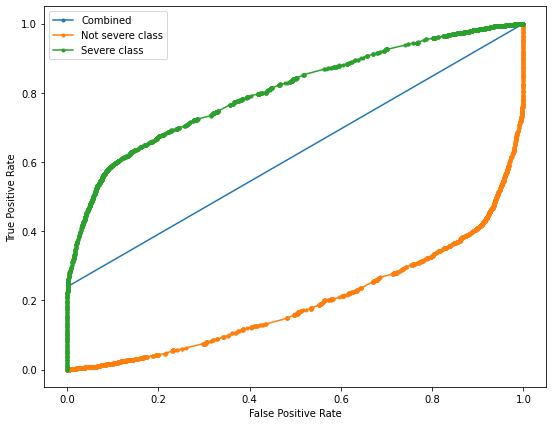

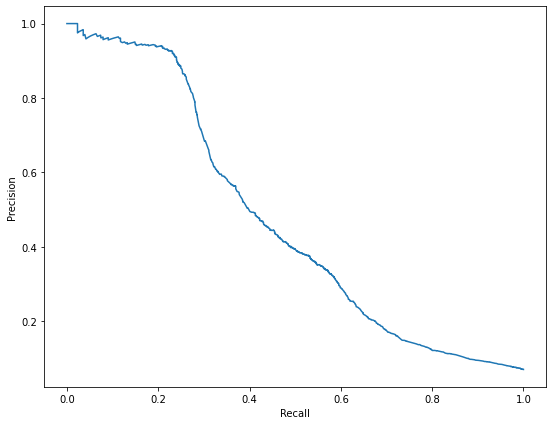

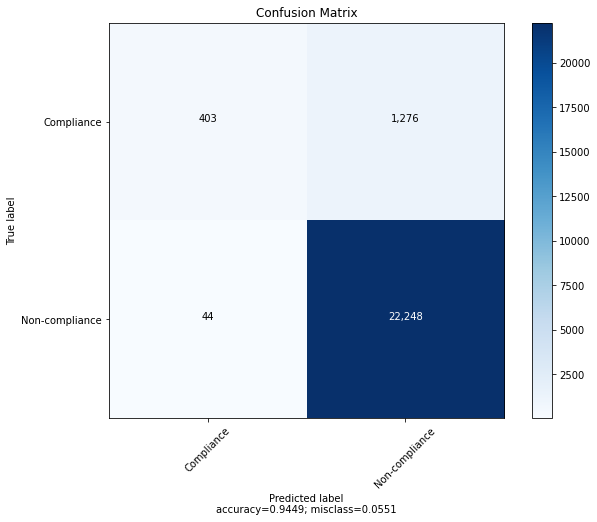

           Feature  Importance
5  time_to_hearing        1612
2      fine_amount         435
4  judgment_amount         385
1      disposition         313
0      agency_name         196
3  discount_amount          59


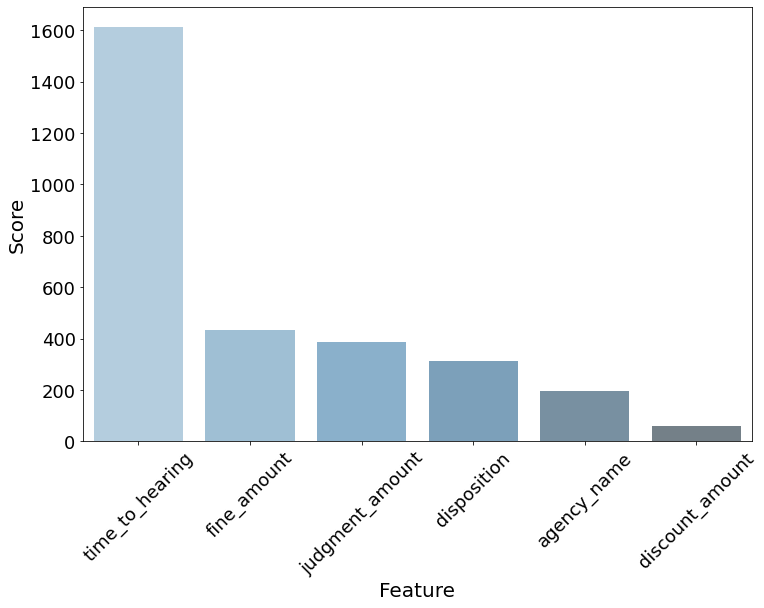

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(LGBMClassifier(random_state=0),x_train,x_test,y_train,y_test)

model_method.append('baseline_lightgbm')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

In [ ]:
'''
params = {'max_depth' : [8,10,12],
    'num_leaves':[25,30,35],
         'learning_rate':[0.05,0.1,0.15],
         'min_data_in_leaf':[800,1000,1200],
         'objective':['binary'],
         }

# Create grid search object
clf = GridSearchCV(LGBMClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit data
best_clf = clf.fit(x_train, y_train)

print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
#clf.cv_results_
'''

"\nparams = {'max_depth' : [8,10,12],\n    'num_leaves':[25,30,35],\n         'learning_rate':[0.05,0.1,0.15],\n         'min_data_in_leaf':[800,1000,1200],\n         'objective':['binary'],\n         }\n\n# Create grid search object\nclf = GridSearchCV(LGBMClassifier(), param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')\n\n# Fit data\nbest_clf = clf.fit(x_train, y_train)\n\nprint (clf.best_estimator_)\nprint (clf.best_score_)\nprint (clf.best_params_)\n#clf.cv_results_\n"

Combined ROC AUC=0.604
Severe class ROC AUC=0.794
Not severe class ROC AUC=0.206
ROC AUC:  0.7940857696113536
Accuracy:  0.9411789245338117
Precision:  0.802247191011236
Recall:  0.21262656343061345
F1 score:  0.3361581920903955
Specificity:  0.9960523954781985


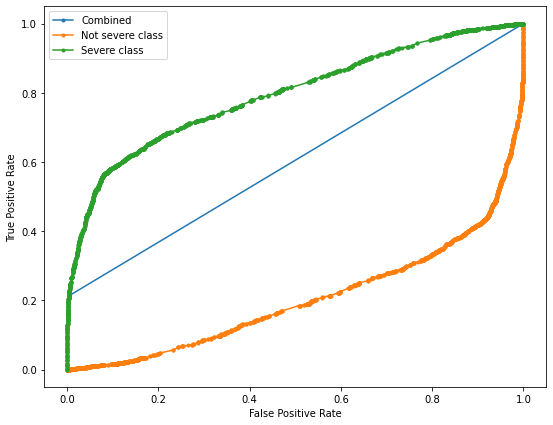

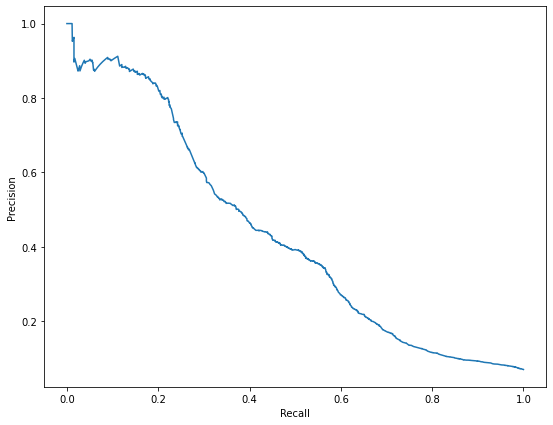

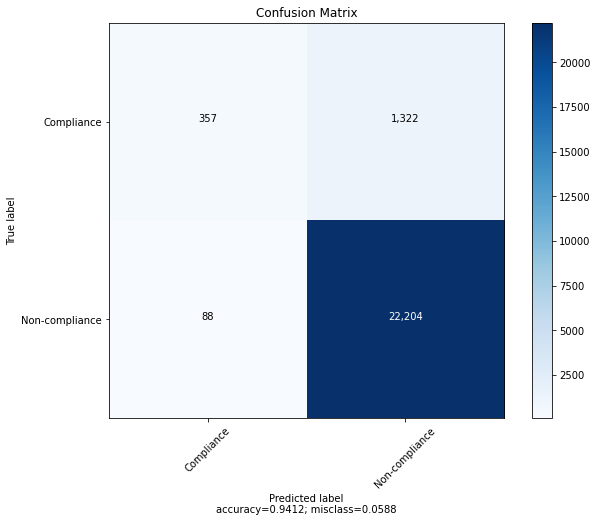

           Feature  Importance
5  time_to_hearing        1992
4  judgment_amount         461
2      fine_amount         352
0      agency_name         231
1      disposition         154
3  discount_amount           0


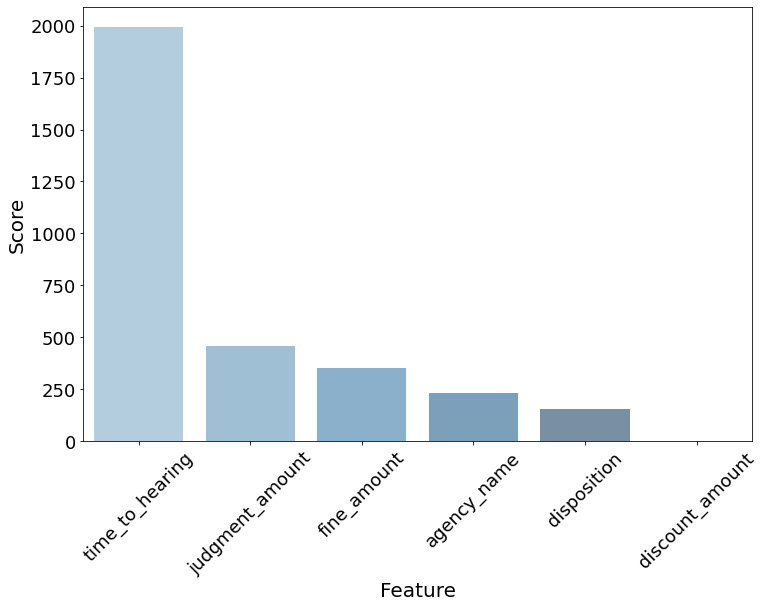

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(LGBMClassifier(random_state=0,learning_rate=0.15,max_depth=10,min_data_in_leaf=800,num_leaves=35),x_train,x_test,y_train,y_test)

model_method.append('optimized_lightgbm')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

Combined ROC AUC=0.606
Severe class ROC AUC=0.803
Not severe class ROC AUC=0.197
ROC AUC:  0.8026475737536132
Accuracy:  0.9435567977973385
Precision:  0.9158163265306123
Recall:  0.21381774865991662
F1 score:  0.34669241912119747
Specificity:  0.9985196483043244


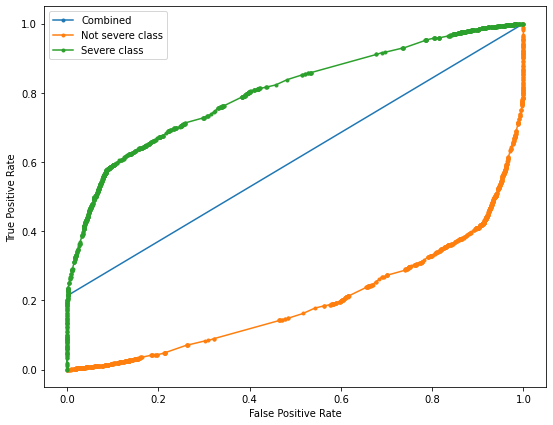

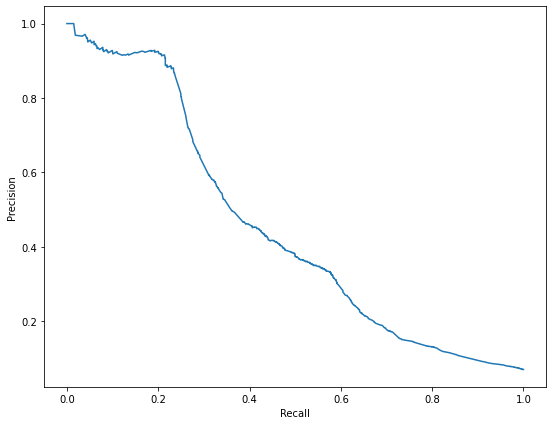

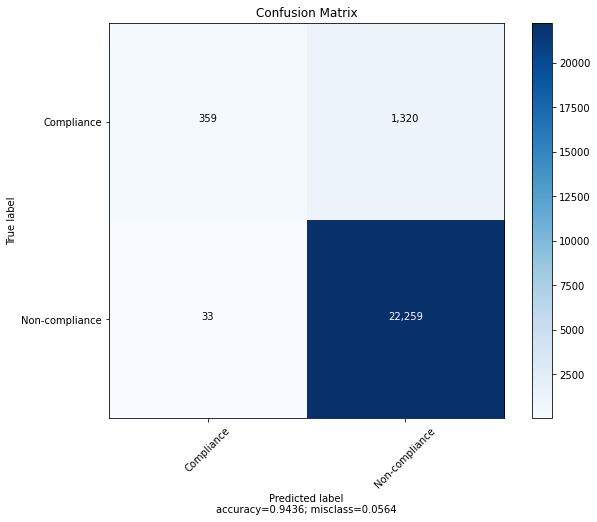

           Feature  Importance
5  time_to_hearing         661
4  judgment_amount         388
2      fine_amount         333
1      disposition         223
0      agency_name         203
3  discount_amount          92


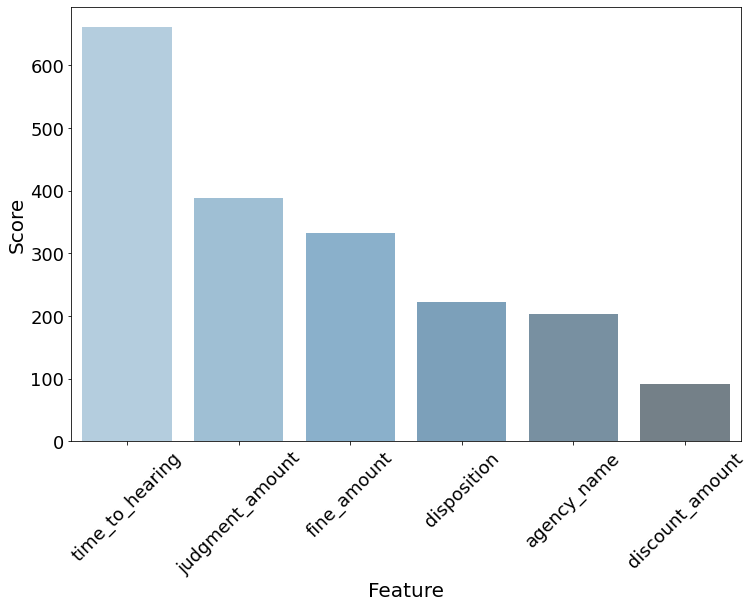

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(LGBMClassifier(random_state=0,learning_rate=0.05,max_depth=10,min_data_in_leaf=200,num_leaves=20),x_train,x_test,y_train,y_test)

model_method.append('optimized2_lightgbm_reduced_learning_rate')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

It doesn't seem like further optimization with the current training will yield better results. 

Combined ROC AUC=0.721
Severe class ROC AUC=0.771
Not severe class ROC AUC=0.229
ROC AUC:  0.7708641367001006
Accuracy:  0.9013808351758374
Precision:  0.3575883575883576
Recall:  0.5122096486003573
F1 score:  0.4211557296767875
Specificity:  0.930692625157007


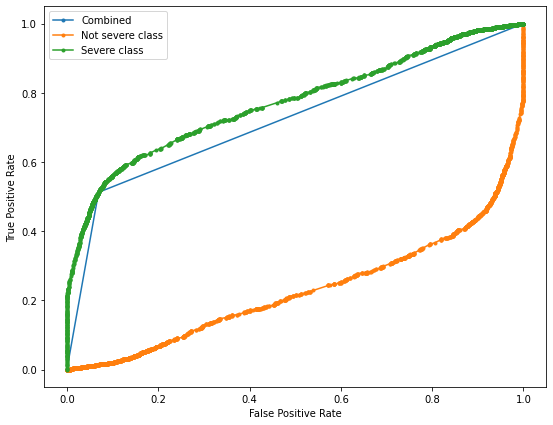

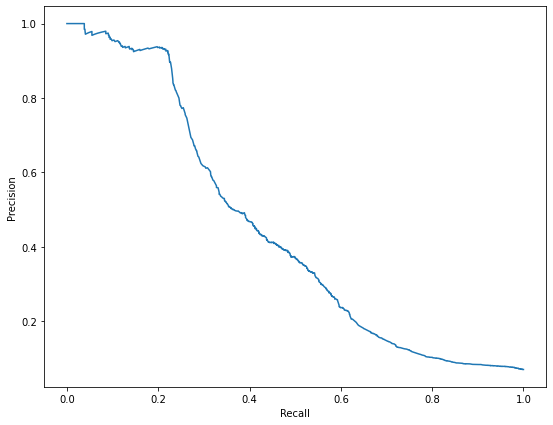

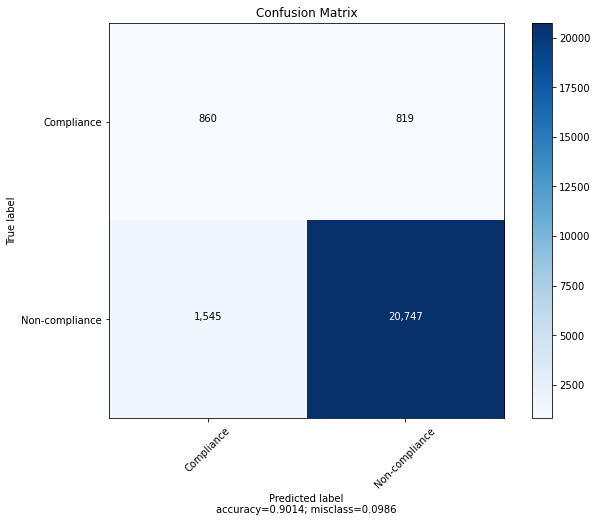

           Feature  Importance
5  time_to_hearing        1378
4  judgment_amount         403
0      agency_name         400
2      fine_amount         396
1      disposition         353
3  discount_amount          70


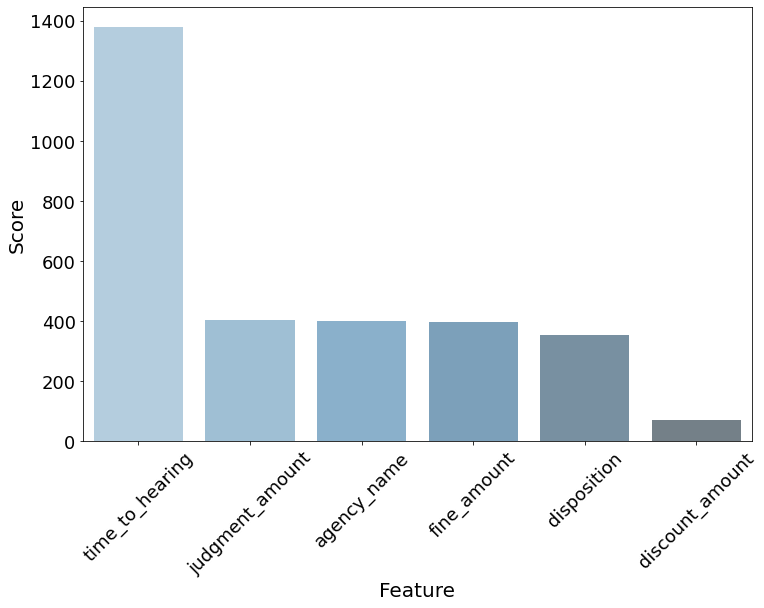

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(LGBMClassifier(random_state=0),x_resampled,x_test,y_resampled,y_test)

model_method.append('oversampled_baseline_lightgbm')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

Combined ROC AUC=0.726
Severe class ROC AUC=0.776
Not severe class ROC AUC=0.224
ROC AUC:  0.7763954639846011
Accuracy:  0.8941637812356598
Precision:  0.33725341426403643
Recall:  0.5294818344252531
F1 score:  0.41205098493626885
Specificity:  0.9216310784137808


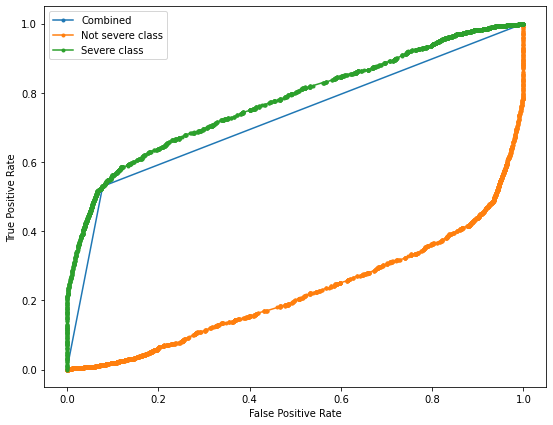

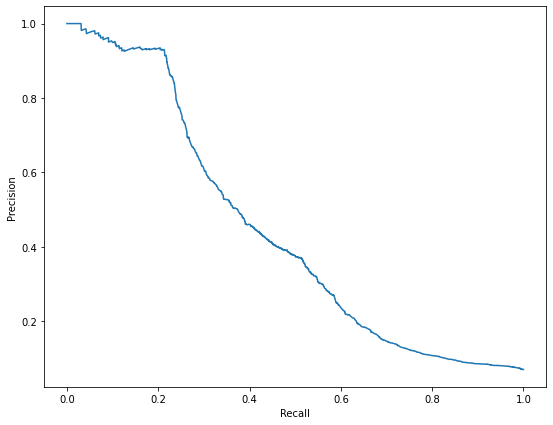

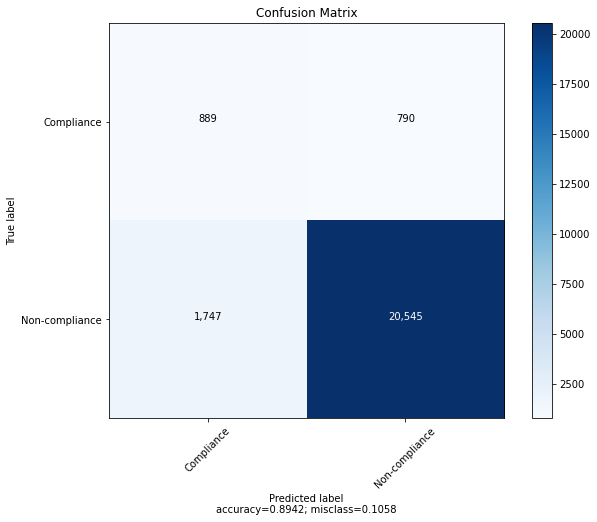

           Feature  Importance
5  time_to_hearing        1407
4  judgment_amount         385
0      agency_name         307
2      fine_amount         259
1      disposition         253
3  discount_amount          50


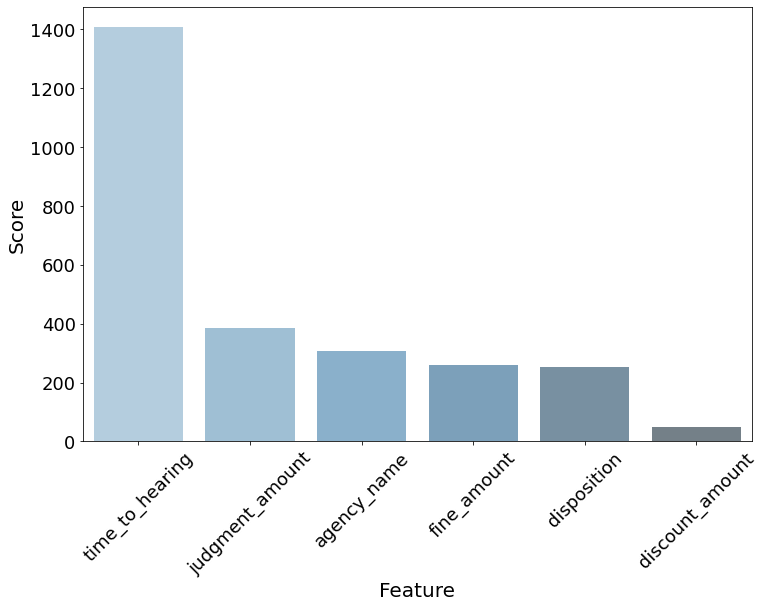

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(LGBMClassifier(random_state=0,learning_rate=0.15,max_depth=10,min_data_in_leaf=800,num_leaves=35),x_resampled,x_test,y_resampled,y_test)

model_method.append('optimized_oversampled_lightgbm')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

Combined ROC AUC=0.736
Severe class ROC AUC=0.788
Not severe class ROC AUC=0.212
ROC AUC:  0.7875032315147471
Accuracy:  0.892661966542906
Precision:  0.33757267441860467
Recall:  0.5533055390113163
F1 score:  0.4193184382757843
Specificity:  0.9182217835994976


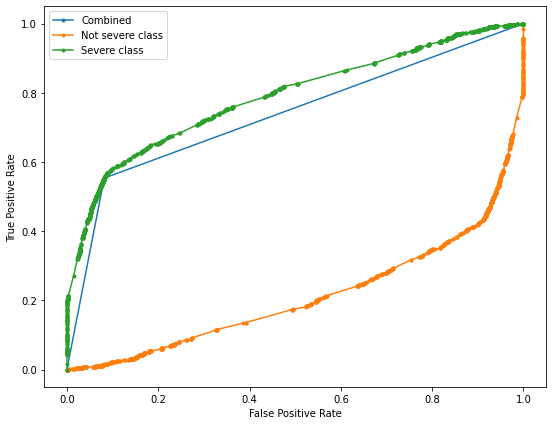

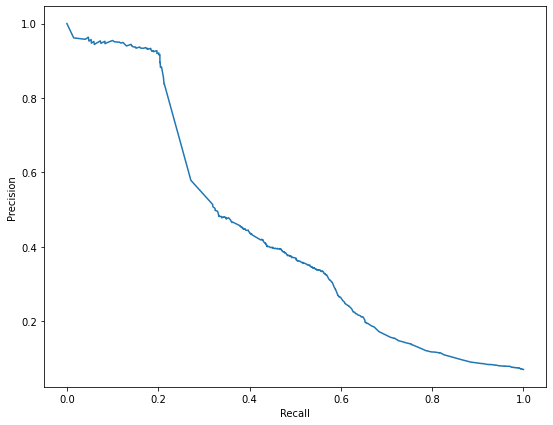

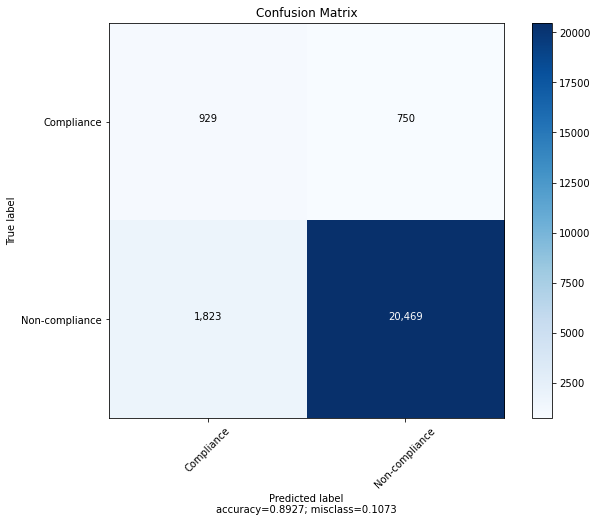

           Feature  Importance
5  time_to_hearing         346
1      disposition         336
0      agency_name         261
4  judgment_amount         235
2      fine_amount         130
3  discount_amount          92


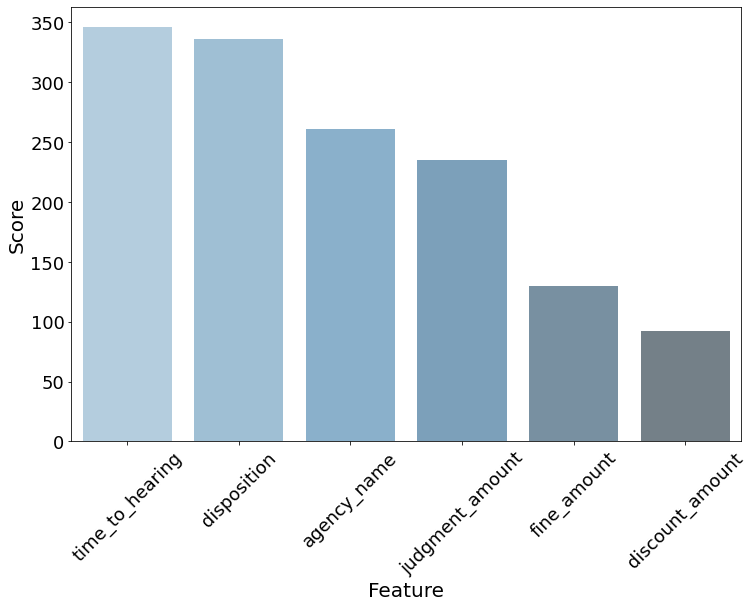

In [ ]:
prec_score, rec_score, acc_score, auc_score, f_score, spec_score = model_predict(LGBMClassifier(random_state=0,learning_rate=0.05,max_depth=10,min_data_in_leaf=800,num_leaves=15),x_resampled,x_test,y_resampled,y_test)

model_method.append('optimized_oversampled_lightgbm_reduced_learning_rate')
prec.append(prec_score)
rec.append(rec_score)
acc.append(acc_score)
auc.append(auc_score)
f1.append(f_score)
spec.append(spec_score)

## 7. Model diagnosis

In [ ]:
model_scores = pd.DataFrame()
model_scores['model'] = model_method
model_scores['accuracy'] = acc
model_scores['precision'] = prec
model_scores['specificity'] = spec
model_scores['recall'] = rec
model_scores['roc_auc'] = auc
model_scores['f1'] = f1

model_scores

,model,accuracy,precision,specificity,recall,roc_auc,f1
0,baseline_logreg_with_one_hot_encoding_and_scaling,0.931751,0.977778,0.999955,0.026206,0.774143,0.051044
1,baseline_logreg,0.935923,0.806867,0.997981,0.111971,0.779348,0.196653
2,baseline_logreg_only_one_hot_encoding,0.939010,0.891697,0.998654,0.147111,0.796276,0.252556
3,optimized_logreg_only_one_hot_encoding,0.935964,0.887097,0.999058,0.098273,0.794454,0.176944
4,oversampled_optimized_logreg_only_one_hot_enco...,0.876309,0.298180,0.899695,0.565813,0.782587,0.390545
5,optimized_oversampled_logreg_only_one_hot_enco...,0.877852,0.304905,0.900188,0.581298,0.795870,0.400000
6,baseline_decisiontrees,0.940845,0.709470,0.991880,0.263252,0.713311,0.384014
7,optimized_decisiontrees,0.932418,0.581717,0.993226,0.125074,0.786398,0.205882
8,baseline_randomforest,0.941638,0.704082,0.990894,0.287671,0.753638,0.408457
9,optimized_randomforest,0.929957,0.000000,1.000000,0.000000,0.795377,0.000000


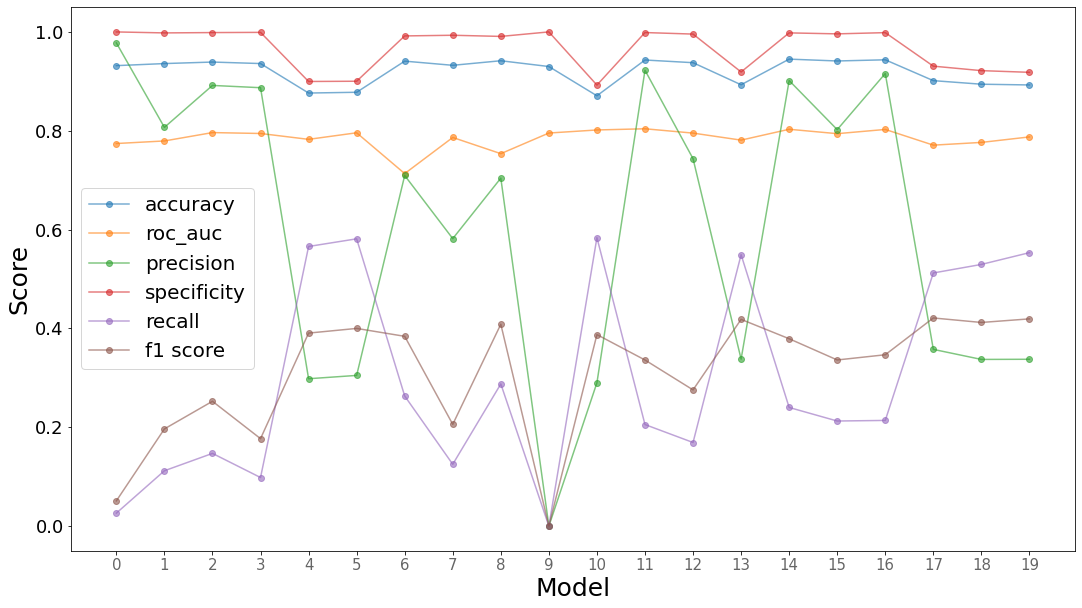

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(model_scores['model'],model_scores['accuracy'],label='accuracy',marker='o',alpha=0.6)
plt.plot(model_scores['model'],model_scores['roc_auc'],label='roc_auc',marker='o',alpha=0.6)
plt.plot(model_scores['model'],model_scores['precision'],label='precision',marker='o',alpha=0.6)
plt.plot(model_scores['model'],model_scores['specificity'],label='specificity',marker='o',alpha=0.6)
plt.plot(model_scores['model'],model_scores['recall'],label='recall',marker='o',alpha=0.6)
plt.plot(model_scores['model'],model_scores['f1'],label='f1 score',marker='o',alpha=0.6)
plt.xticks(range(len(model_scores['model'])),range(len(model_scores['model'])),alpha=0.6,size=15)
plt.xlabel('Model',size=25)
plt.ylabel('Score',size=25)
plt.yticks(size=18)
plt.legend(prop={'size': 20})

### 7.1 Observations

The following observations can be made regarding the above results: 
- The **accuracy, specificity and ROC AUC scores are essentially the same across all models** with very minute differences
- There is a **larger fluctuation in precision and recall scores**.  

### 7.2 Picking the right metric

For our application of predicting which individuals are likely to be compliant and which are not, we need to determine **what the cost is of a wrong prediction**. In other words, would false negatives be more costly or false positives? 

Since it's a tedious and expensive process for the authorities to enforce unpaid blight fines, the idea is to identify individuals who may not pay the fines on time and **proactively take early steps to ensure that fines are paid** or **engage with them to understand why they are not able to maintain their properties**.  

As the costs to enforce the fines early are far less than doing so after an upaid fine, it would be a better solution to identify as many people who may be non-compliant which would be a true negative in this case. Hence, we want to reduce the number of false positives as much as possible which in turn would mean **greater specificity and precision scores**. 

Hence recall is not that important whereas specificity is the metric that needs to be optimized since it focuses on reducing false positives and increasing true negatives. These considerations are the most critical for our application of identifying individuals who may fail to pay fines on time.  


### 7.3 The final model

Based on the reasoning above, there are several models that could work for our application. A few of the models that could work well are: 
- **Model 0**: Baseline Logistic Regression
- **Model 2/3**: Logistic regression model with only OHE and no scaling
- **Model 11**: Baseline Gradient Boosting model
- **Model 14**: Baseline LightGBM 
- **Model 16**: Optimized LightGBM 
- **Model 19**: Oversamlpled and optimized LightGBM

Most important metrics: 
- **ROC AUC**: The best models for this metric are the Gradient Boosting and LightGBM models which have scores close to 0.8. 
- **Specificity**: All the above models have a really high specificity score. Therefore, in order to determine the final model, we can simply look at the ROC AUC and precision scores. 
- **Precision**: Model 0 is better than the tree-based models for precision. 
- **Accuracy**: Similar to specificity, accuracy is fairly high for most of the above models. 
- **Recall**: It is not as important as the other metrics but can be used to differentiate between models which are hard to distinguish. 

Based on the above metrics, we picked Model 19 which is the oversampled and optimized LightBGM model. A few reasons for picking this model are: 
- It provides a relatively high **ROC AUC scores of 0.788**
- It provides **high accuracy and specificity scores of 0.892 and 0.918**
- It would generalize to unseen data better since it's oversampled. Some of the other models where the minority class is not oversampled tended to have an unusually high specificity score greater than 0.99 which indicates that they possibly maybe predicting a lot of instances as non-compliant. Since that is the majority class, the bias is not completely apparent. Therefore, it's best to go with an oversampled model even though the resulting specificity is not the highest. 
- Since it's a tree-based model, we can see the best predictors
- LGBM is a faster version of Gradient Boosting and also takes less memory to operate


## 8. Predicting unseen data

In [ ]:
test_df.shape

(61001, 6)

In [ ]:
test_df.head()

,agency_name,disposition,fine_amount,discount_amount,judgment_amount,time_to_hearing
0,1,5,200.0,0.0,250.0,14
1,1,5,1000.0,0.0,1130.0,31
2,1,5,100.0,0.0,140.0,31
3,1,5,200.0,0.0,250.0,32
4,1,5,100.0,0.0,140.0,39


In [ ]:
x_test.shape

(23971, 6)

In [ ]:
'''
x_train = pd.DataFrame(x_train)
x_train.columns = x.columns
x_test = pd.DataFrame(x_test)
x_test.columns = x.columns
y_train = pd.DataFrame(y_train)
#y_train.columns = 'compliance'
y_test = pd.DataFrame(y_test)
#y_test.columns = 'compliance'
'''
#Modeling and prediction
#model = LGBMClassifier(random_state=0,learning_rate=0.05,max_depth=10,min_data_in_leaf=200,num_leaves=20).fit(x_train,y_train)
#model = RandomForestClassifier(random_state=0,max_depth=20,max_features='log2',min_samples_leaf=500).fit(x_resampled,y_resampled)
model = LGBMClassifier(random_state=0,learning_rate=0.05,max_depth=10,min_data_in_leaf=800,num_leaves=15).fit(x_resampled,y_resampled)
final_pred = model.predict(test_df)

#Calculating prediction probabilities
lr_probs = model.predict_proba(x_test)
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

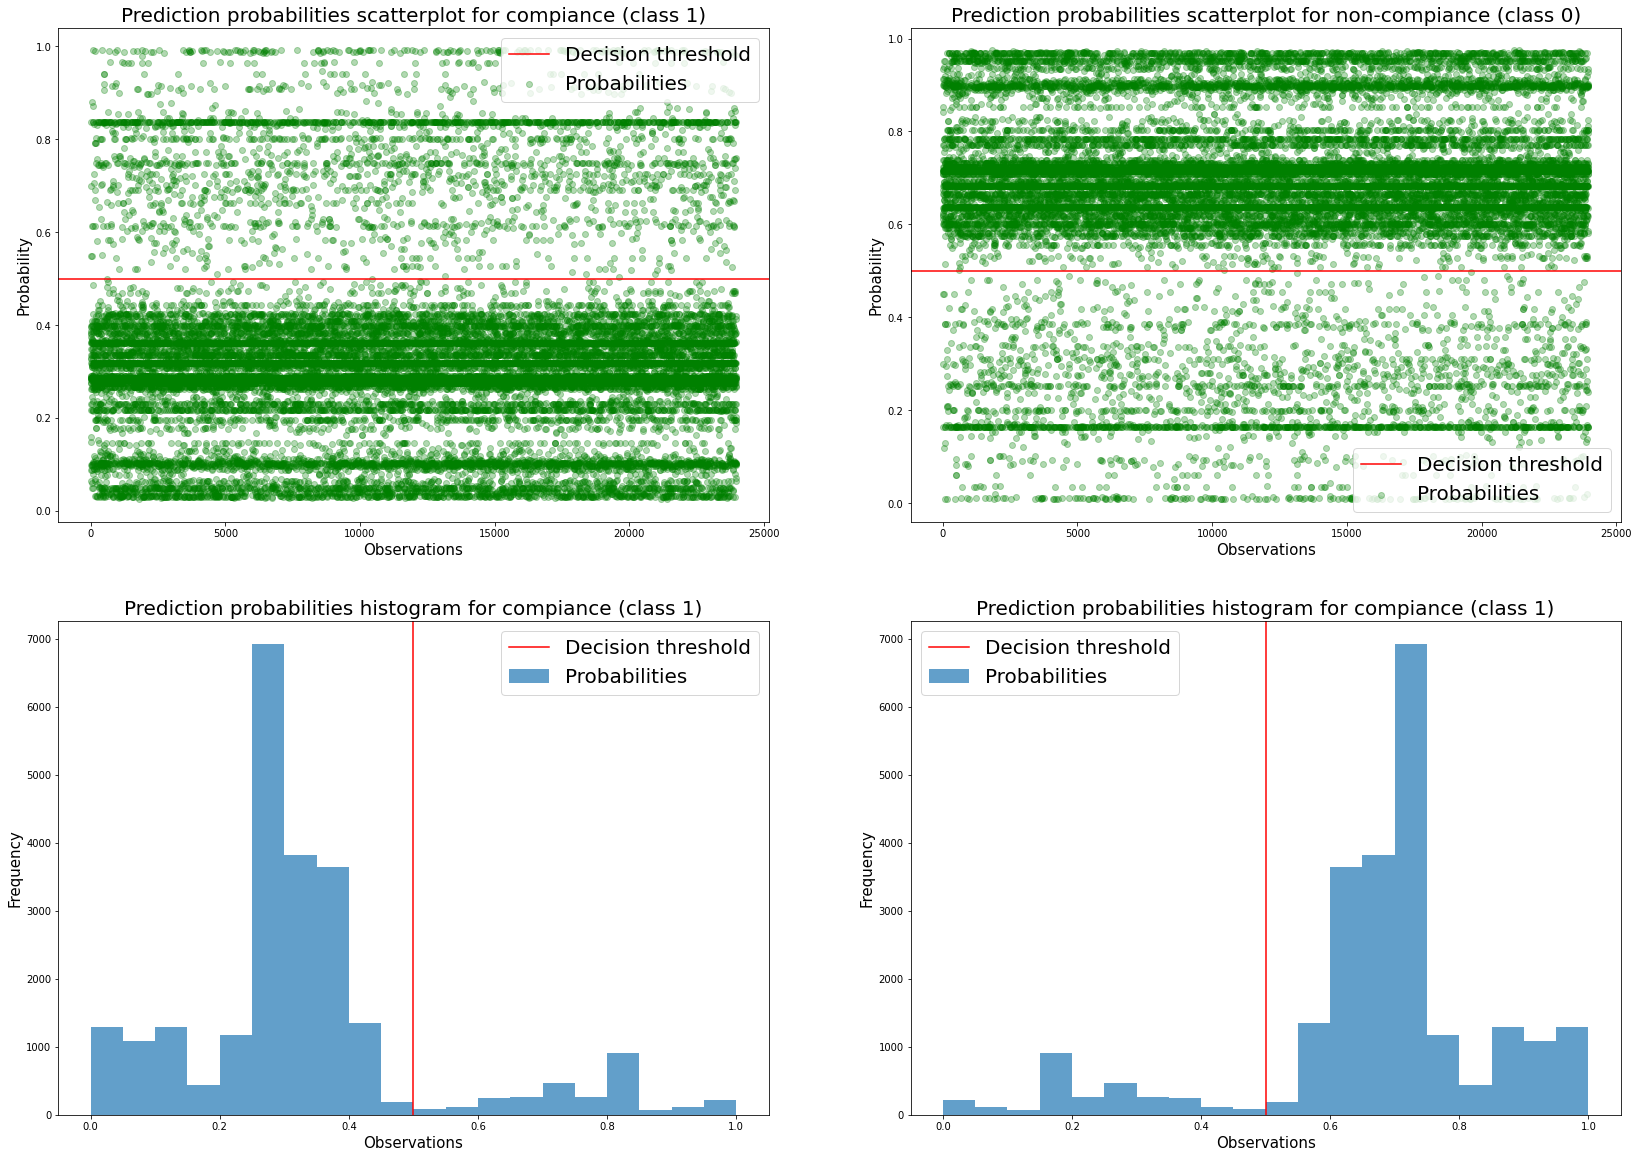

In [ ]:
plt.figure(figsize=(28,20))
plt.subplot(2,2,1)
plt.scatter(range(len(lr_probs_pos)),lr_probs_pos,color='green',alpha=0.3,label='Probabilities')
plt.axhline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities scatterplot for compiance (class 1)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Probability',size=15)
plt.legend(loc='upper right',prop={'size': 20})

plt.subplot(2,2,2)
plt.scatter(range(len(lr_probs_neg)),lr_probs_neg,color='green',alpha=0.3,label='Probabilities')
plt.axhline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities scatterplot for non-compiance (class 0)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Probability',size=15)
plt.legend(loc='lower right',prop={'size': 20})

plt.subplot(2,2,3)
plt.hist(lr_probs_pos,range=(0,1),bins=20,alpha=0.7,label='Probabilities')
plt.axvline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities histogram for compiance (class 1)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Frequency',size=15)
plt.legend(prop={'size': 20})

plt.subplot(2,2,4)
plt.hist(lr_probs_neg,range=(0,1),bins=20,alpha=0.7,label='Probabilities')
plt.axvline(0.5,color='red',label='Decision threshold')
plt.title('Prediction probabilities histogram for compiance (class 1)',size=20)
plt.xlabel('Observations',size=15)
plt.ylabel('Frequency',size=15)
plt.legend(prop={'size': 20})

In [ ]:
print ("Percentage predicted as compliant:",(sum(lr_probs_pos > 0.5)/len(lr_probs_pos))*100)
print ("Percentage predicted as non-compliant:",(sum(lr_probs_neg > 0.5)/len(lr_probs_neg))*100)

Percentage predicted as compliant: 11.4805389846064
Percentage predicted as non-compliant: 88.5194610153936


In [ ]:
lr_probs[:50]

array([[0.68210415, 0.31789585],
       [0.70943976, 0.29056024],
       [0.16352981, 0.83647019],
       [0.90036977, 0.09963023],
       [0.71516968, 0.28483032],
       [0.665019  , 0.334981  ],
       [0.71516968, 0.28483032],
       [0.9125454 , 0.0874546 ],
       [0.45069784, 0.54930216],
       [0.72450056, 0.27549944],
       [0.60140083, 0.39859917],
       [0.6250238 , 0.3749762 ],
       [0.61940031, 0.38059969],
       [0.61236026, 0.38763974],
       [0.70943976, 0.29056024],
       [0.85271655, 0.14728345],
       [0.84093919, 0.15906081],
       [0.71516968, 0.28483032],
       [0.67380531, 0.32619469],
       [0.93503108, 0.06496892],
       [0.77109711, 0.22890289],
       [0.63597829, 0.36402171],
       [0.71681046, 0.28318954],
       [0.61805766, 0.38194234],
       [0.73830414, 0.26169586],
       [0.3002812 , 0.6997188 ],
       [0.63837634, 0.36162366],
       [0.71516968, 0.28483032],
       [0.72450056, 0.27549944],
       [0.78327918, 0.21672082],
       [0.

In [ ]:
'''
max_depth = range(5,13,1)
min_data_in_leaf=range(500,1500,100)
num_leaves=range(5,45,5)
auc_list_train = []
auc_list_test = []

for i in max_depth: 
  #for j in min_data_in_leaf: 
  for k in num_leaves:
    #Modeling and prediction
    model = LGBMClassifier(random_state=0,learning_rate=0.15,max_depth=i,min_data_in_leaf=800,num_leaves=k).fit(x_resampled,y_resampled)

    prediction = model.predict(x_train)

    #Calculating prediction probabilities
    lr_probs = model.predict_proba(x_train)
    lr_probs_pos = lr_probs[:,1]
    lr_probs_neg = lr_probs[:,0]

    #Calculating ROC AUC values
    lr_auc = roc_auc_score(y_train, prediction)
    lr_auc_pos = roc_auc_score(y_train, lr_probs_pos)
    lr_auc_neg = roc_auc_score(y_train, lr_probs_neg)

    auc_list_train.append(lr_auc_pos)

    prediction = model.predict(x_test)

    #Calculating prediction probabilities
    lr_probs = model.predict_proba(x_test)
    lr_probs_pos = lr_probs[:,1]
    lr_probs_neg = lr_probs[:,0]

    #Calculating ROC AUC values
    lr_auc = roc_auc_score(y_test, prediction)
    lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
    lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

    auc_list_test.append(lr_auc_pos)
    '''

'\nmax_depth = range(5,13,1)\nmin_data_in_leaf=range(500,1500,100)\nnum_leaves=range(5,45,5)\nauc_list_train = []\nauc_list_test = []\n\nfor i in max_depth: \n  #for j in min_data_in_leaf: \n  for k in num_leaves:\n    #Modeling and prediction\n    model = LGBMClassifier(random_state=0,learning_rate=0.15,max_depth=i,min_data_in_leaf=800,num_leaves=k).fit(x_resampled,y_resampled)\n\n    prediction = model.predict(x_train)\n\n    #Calculating prediction probabilities\n    lr_probs = model.predict_proba(x_train)\n    lr_probs_pos = lr_probs[:,1]\n    lr_probs_neg = lr_probs[:,0]\n\n    #Calculating ROC AUC values\n    lr_auc = roc_auc_score(y_train, prediction)\n    lr_auc_pos = roc_auc_score(y_train, lr_probs_pos)\n    lr_auc_neg = roc_auc_score(y_train, lr_probs_neg)\n\n    auc_list_train.append(lr_auc_pos)\n\n    prediction = model.predict(x_test)\n\n    #Calculating prediction probabilities\n    lr_probs = model.predict_proba(x_test)\n    lr_probs_pos = lr_probs[:,1]\n    lr_probs_neg